In [1]:
pip install --upgrade bottleneck

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pandas dask

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install optuna category_encoders

In [4]:
import pandas as pd
import numpy as np
import bisect
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder

In [5]:
train = pd.read_csv("train.csv").drop(columns = ['SAMPLE_ID'])
test = pd.read_csv("test.csv").drop(columns = ['SAMPLE_ID'])
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

In [6]:
for df in [train, test]: # 날짜 정보 각각을 column에 추가
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

In [7]:
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [8]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,SG,GIW5,Container,30.881018,Z618338,30.0,24,24300,10.0,10.0,...,NaN,5,0.002615,3.450000,2018,12,17,21,29,0
1,IN,UJM2,Bulk,0.000000,X886125,30.0,13,35900,10.0,10.0,...,NaN,12,0.000217,0.000000,2014,9,23,6,59,1
2,CN,EUC8,Container,0.000000,T674582,50.0,12,146000,30.0,20.0,...,NaN,6,0.001614,0.000000,2015,2,3,22,0,1
3,JP,ZAG4,Container,0.000000,Y847238,20.0,18,6910,10.0,10.0,...,2.629350,13,0.000356,0.000000,2020,1,17,4,2,4
4,SG,GIW5,Container,27.037650,A872328,50.0,10,116000,20.0,10.0,...,2.495953,15,0.002615,253.554444,2020,1,26,7,51,6


# EDA

In [9]:
train.info() #데이터 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ID                  391939 non-null  object 
 5   BREADTH             391938 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391938 non-null  float64
 9   DRAUGHT             391938 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391938 non-null  float64
 12  SHIPMANAGER         391939 non-null  object 
 13  FLAG                391939 non-null  object 
 14  U_WIND              228251 non-null  float64
 15  V_WIND              228251 non-nul

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  object 
 1   ARI_PO              220491 non-null  object 
 2   SHIP_TYPE_CATEGORY  220491 non-null  object 
 3   DIST                220491 non-null  float64
 4   ID                  220491 non-null  object 
 5   BREADTH             220491 non-null  float64
 6   BUILT               220491 non-null  int64  
 7   DEADWEIGHT          220491 non-null  int64  
 8   DEPTH               220491 non-null  float64
 9   DRAUGHT             220491 non-null  float64
 10  GT                  220491 non-null  int64  
 11  LENGTH              220491 non-null  float64
 12  SHIPMANAGER         220491 non-null  object 
 13  FLAG                220491 non-null  object 
 14  U_WIND              128766 non-null  float64
 15  V_WIND              128766 non-nul

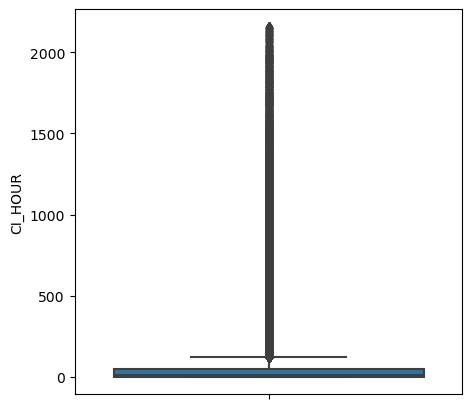

In [11]:
# target 분포 확인

plt.figure(figsize = (5, 5))
sns.boxplot(data = train, y = 'CI_HOUR')

plt.show()

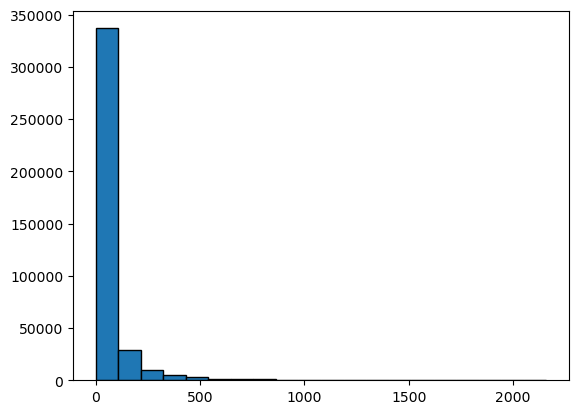

In [12]:
plt.hist(train['CI_HOUR'], bins = 20, edgecolor = 'black')
plt.show()

In [13]:
train['CI_HOUR'] = np.log1p(train['CI_HOUR'])

In [14]:
train['CI_HOUR'] = data

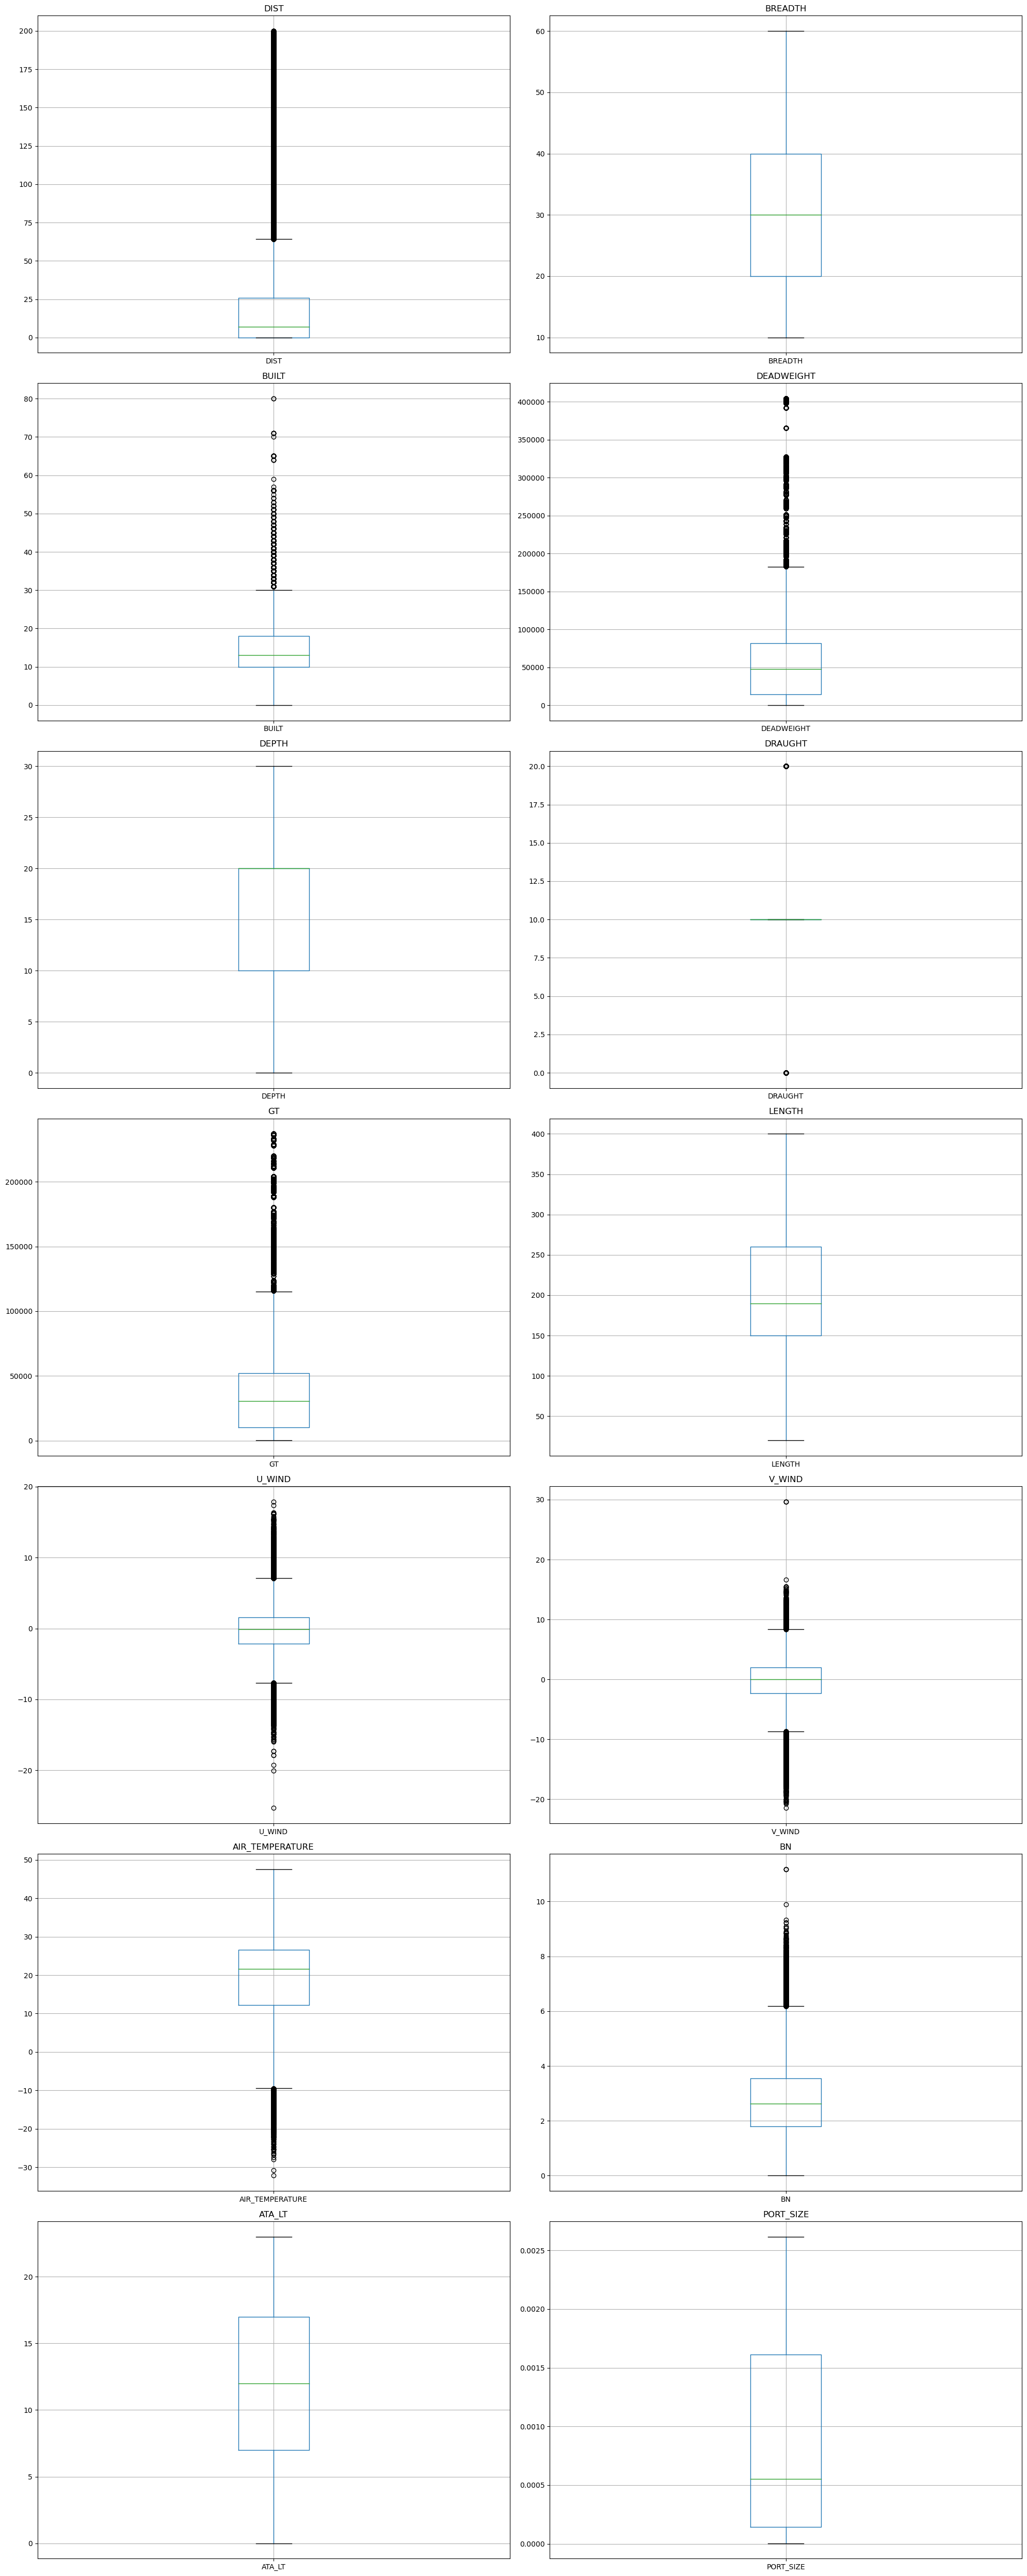

In [15]:
# 실수형 feature 이상치 check

columns_to_exclude = ['CI_HOUR', 'year', 'month', 'day', 'hour', 'minute', 'weekday']
numeric_data = train.select_dtypes(include=['float64', 'int64'])
numeric_data = numeric_data.drop(columns=columns_to_exclude, errors='ignore')

plt.figure(figsize=(20, 50))

for idx, column  in enumerate(numeric_data.columns):
    plt.subplot(7, 2, idx+1)
    train.boxplot(column=column)
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

DIST, BUILT, DEADWEIGHT, GT, U_WIND, V_WIND, AIR_TEMPERATURE, BN에서 이상치가 존재
그러나 이상치라고 하더라도 feature의 특성을 고려함과 동시에 많은 이상치 영역 데이터들이 몰려있는 부분이 많아 합리적인 데이터일 수 있음
극단적인 값이 오히려 없어 전처리 없이 그대로 활용하고
비어있는 데이터에 대해서는 평균값을 활용함

In [16]:
# object type feature encoding


categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le


Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


In [17]:
from sklearn.impute import SimpleImputer

categorical_imputer = SimpleImputer(strategy='most_frequent')
train[categorical_features] = categorical_imputer.fit_transform(train[categorical_features])
test[categorical_features] = categorical_imputer.fit_transform(test[categorical_features])

In [18]:
numeric_imputer = SimpleImputer(strategy='mean')
train[numeric_data.columns] = numeric_imputer.fit_transform(train[numeric_data.columns])
test[numeric_data.columns] = numeric_imputer.fit_transform(test[numeric_data.columns])

In [19]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,17,21,2,30.881018,24710,30.0,24.0,24300.0,10.0,10.0,...,2.706992,5.0,0.002615,1.492904,2018,12,17,21,29,0
1,7,81,0,0.000000,23140,30.0,13.0,35900.0,10.0,10.0,...,2.706992,12.0,0.000217,0.000000,2014,9,23,6,59,1
2,4,14,2,0.000000,19009,50.0,12.0,146000.0,30.0,20.0,...,2.706992,6.0,0.001614,0.000000,2015,2,3,22,0,1
3,8,101,2,0.000000,24048,20.0,18.0,6910.0,10.0,10.0,...,2.629350,13.0,0.000356,0.000000,2020,1,17,4,2,4
4,17,21,2,27.037650,911,50.0,10.0,116000.0,20.0,10.0,...,2.495953,15.0,0.002615,5.539515,2020,1,26,7,51,6


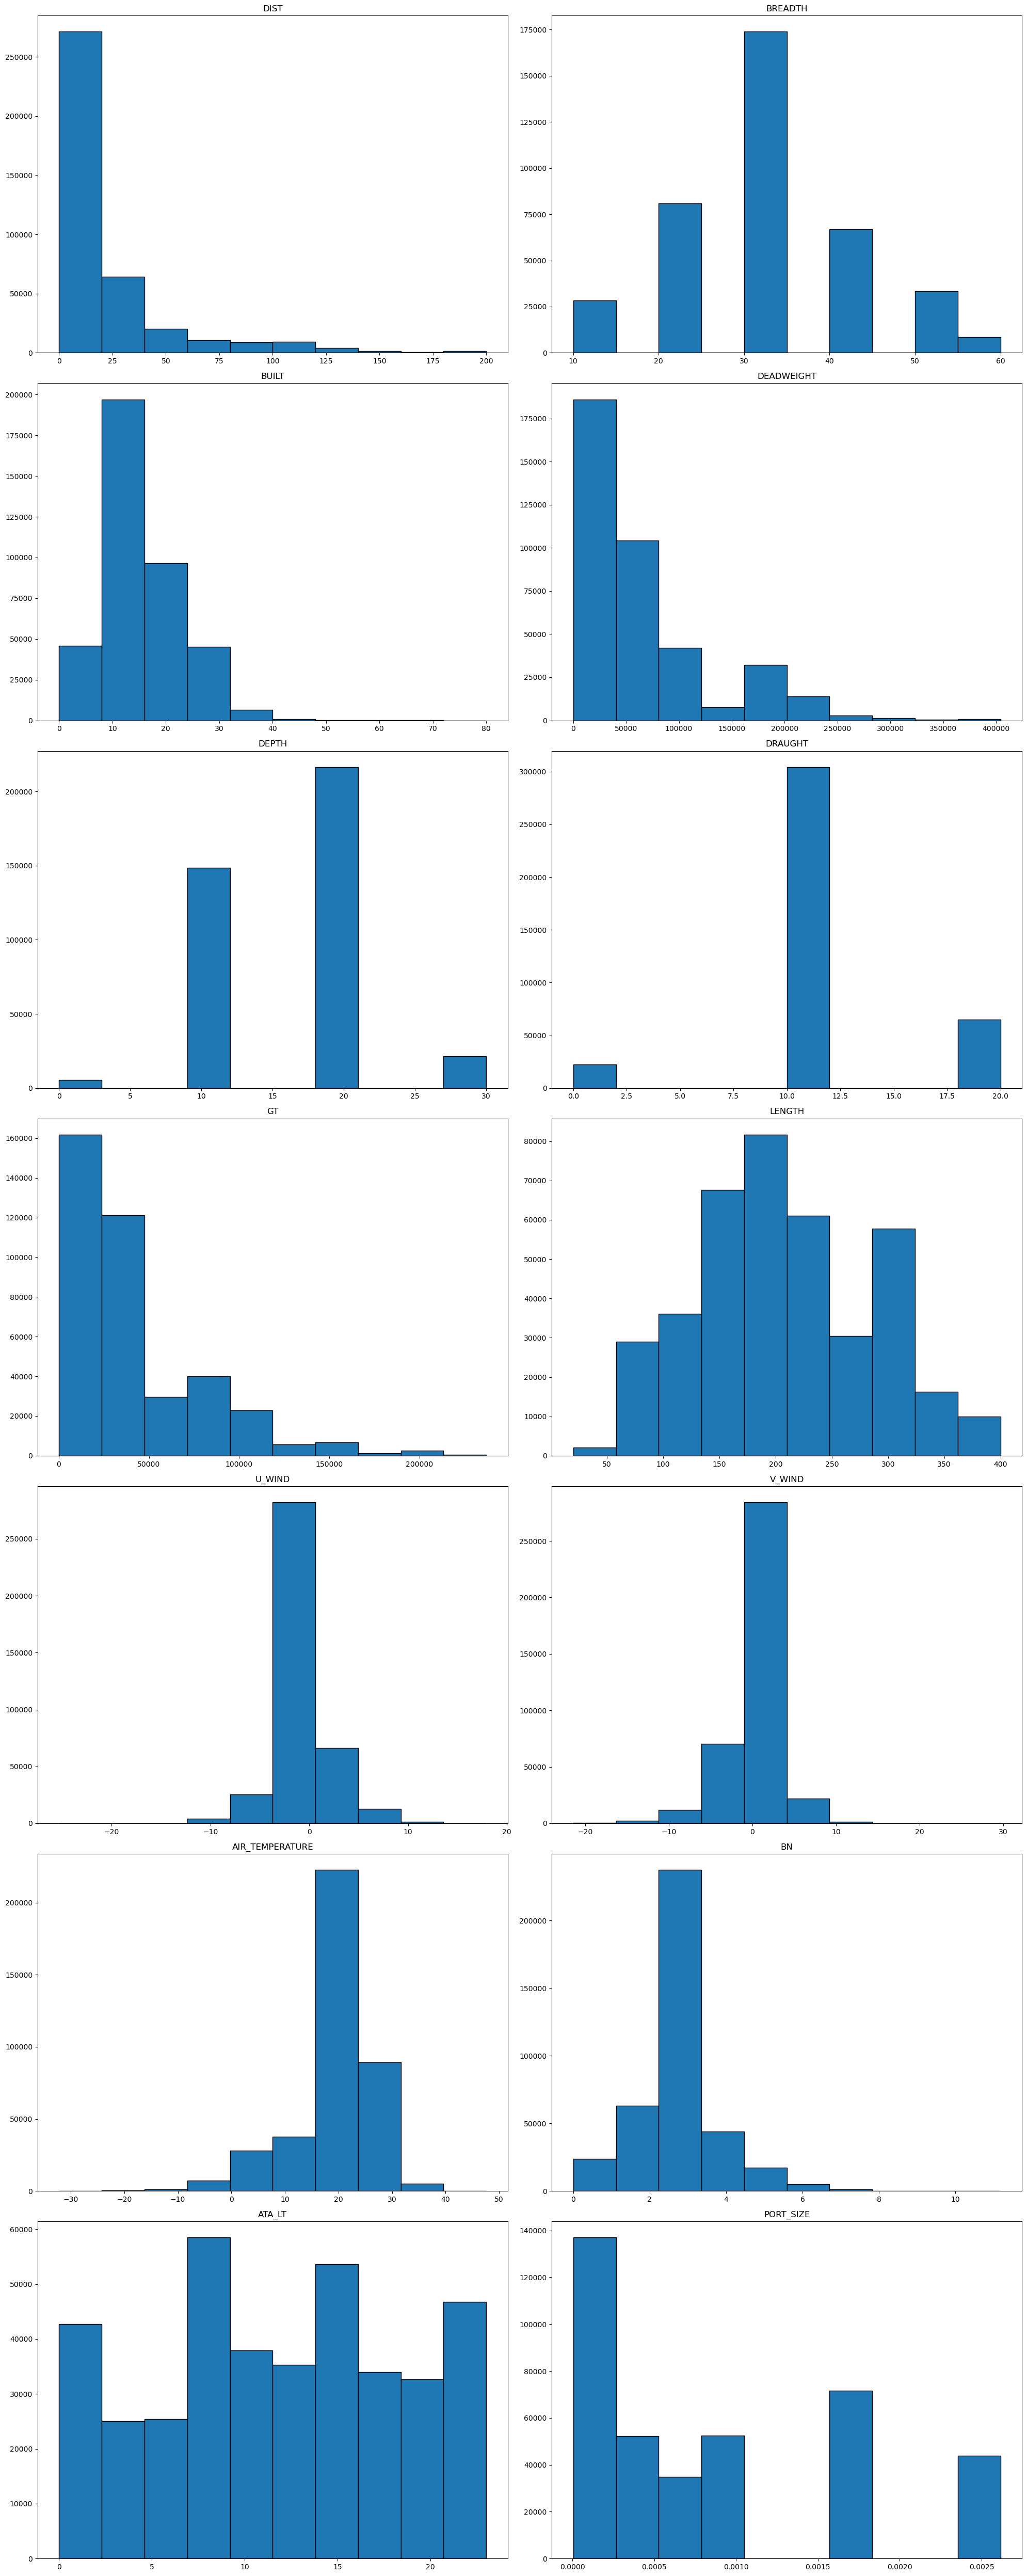

In [20]:
# skewness 데이터가 있는지 확인

plt.figure(figsize = (20 ,50))

for idx, column  in enumerate(numeric_data.columns):
    plt.subplot(7, 2, idx+1)
    plt.hist(train[column], edgecolor = 'black')
    plt.title(f'{column}')
    
plt.tight_layout()
plt.show()

DIST, DEADWEIGHT, GT에 대해서 log1p

In [21]:
train['DIST'] = np.log1p(train['DIST'])
test['DIST'] = np.log1p(test['DIST'])

train['DEADWEIGHT'] = np.log1p(train['DEADWEIGHT'])
test['DEADWEIGHT'] = np.log1p(test['DEADWEIGHT'])

train['GT'] = np.log1p(train['GT'])
test['GT'] = np.log1p(test['GT'])

In [22]:
def get_season(month):
    if month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4
    else:
        return 1

In [23]:
train['WIND_INTENSITY'] = np.sqrt(train['U_WIND']**2 + train['V_WIND']**2)
test['WIND_INTENSITY'] = np.sqrt(test['U_WIND']**2 + test['V_WIND']**2)
train['U_WIND_SQUARE'] = train['U_WIND'] ** 2
test['U_WIND_SQUARE'] = test['U_WIND'] ** 2
train['V_WIND_SQUARE'] = train['V_WIND'] ** 2
test['V_WIND_SQUARE'] = test['V_WIND'] ** 2
train['SEASON'] = train['month'].apply(get_season)
test['SEASON'] = test['month'].apply(get_season)
train['WEEKEND'] = train['weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['WEEKEND'] = test['weekday'].apply(lambda x: 1 if x >= 5 else 0)
train['VOLUME'] = train['BREADTH'] * train['LENGTH'] * train['DEPTH']
test['VOLUME'] = test['BREADTH'] * test['LENGTH'] * test['DEPTH']
train['WIND_DIRECTION'] = np.arctan2(train['V_WIND'], train['U_WIND']) * (180/np.pi)
test['WIND_DIRECTION'] = np.arctan2(test['V_WIND'], test['U_WIND']) * (180/np.pi)
train['WIND_DIRECTION'] = train['WIND_DIRECTION'].apply(lambda x: x+360 if x < 0 else x)
test['WIND_DIRECTION'] = test['WIND_DIRECTION'].apply(lambda x: x+360 if x < 0 else x)
train['WIND_SPEED_DIR'] = train['WIND_INTENSITY'] * train['WIND_DIRECTION']
test['WIND_SPEED_DIR'] = test['WIND_INTENSITY'] * test['WIND_DIRECTION']

# Heatmap -> feature selection

In [24]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,SEASON,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR
0,17,21,2,3.462011,24710,30.0,24.0,10.098273,10.0,10.0,...,29,0,0.395712,0.086972,0.069616,1,0,54000.0,221.818222,87.776132
1,7,81,0,0.000000,23140,30.0,13.0,10.488520,10.0,10.0,...,59,1,0.395712,0.086972,0.069616,4,0,54000.0,221.818222,87.776132
2,4,14,2,0.000000,19009,50.0,12.0,11.891369,30.0,20.0,...,0,1,0.395712,0.086972,0.069616,1,0,555000.0,221.818222,87.776132
3,8,101,2,0.000000,24048,20.0,18.0,8.840870,10.0,10.0,...,2,4,3.564337,10.112400,2.592100,1,0,24000.0,206.852606,737.292448
4,17,21,2,3.333548,911,50.0,10.0,11.661354,20.0,10.0,...,51,6,3.296559,0.108900,10.758400,1,1,300000.0,264.254818,871.131550


In [25]:
train_co = train
train_co.corr()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,SEASON,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR
ARI_CO,1.000000,-0.325477,2.932266e-01,-0.190509,-0.012398,-0.164839,0.103380,-0.220549,-0.164790,-0.191685,...,0.025197,-0.046781,0.013414,-0.049536,0.079319,-0.008677,-0.073057,-0.138735,-1.084296e-02,0.029492
ARI_PO,-0.325477,1.000000,-2.088252e-01,0.057614,0.011478,-0.008607,-0.028334,0.013349,-0.019853,0.051273,...,-0.004698,0.027644,-0.013078,0.037876,-0.080220,0.009714,0.033603,-0.015630,-2.885293e-02,-0.030987
SHIP_TYPE_CATEGORY,0.293227,-0.208825,1.000000e+00,-0.105551,-0.001181,-0.220359,0.105902,-0.394826,-0.258883,-0.261660,...,0.072226,-0.064554,-0.014658,-0.057497,0.017591,-0.038454,-0.104681,-0.109980,-3.173170e-07,0.005115
DIST,-0.190509,0.057614,-1.055513e-01,1.000000,-0.002637,0.057264,-0.009574,0.075457,0.028632,0.087845,...,0.003726,0.168571,-0.001333,-0.005228,-0.037303,-0.003516,0.323925,0.025033,-3.085804e-02,-0.020327
ID,-0.012398,0.011478,-1.181396e-03,-0.002637,1.000000,-0.002034,-0.002559,-0.006295,-0.003723,0.000993,...,-0.000888,-0.002188,-0.010318,-0.006141,-0.008864,0.001019,-0.004444,0.003307,3.503381e-03,-0.007993
BREADTH,-0.164839,-0.008607,-2.203592e-01,0.057264,-0.002034,1.000000,-0.209512,0.897080,0.790476,0.761323,...,-0.047606,0.015091,-0.048898,0.016581,-0.038928,0.003053,0.031568,0.891938,2.007266e-02,-0.051194
BUILT,0.103380,-0.028334,1.059017e-01,-0.009574,-0.002559,-0.209512,1.000000,-0.201959,-0.205492,-0.146957,...,-0.024001,-0.009776,-0.067692,-0.050225,-0.016696,0.007340,-0.011272,-0.224125,2.136827e-02,-0.049821
DEADWEIGHT,-0.220549,0.013349,-3.948261e-01,0.075457,-0.006295,0.897080,-0.201959,1.000000,0.826978,0.758012,...,-0.062496,0.025856,-0.059391,0.016859,-0.046328,0.006792,0.049681,0.751644,1.949274e-02,-0.066261
DEPTH,-0.164790,-0.019853,-2.588833e-01,0.028632,-0.003723,0.790476,-0.205492,0.826978,1.000000,0.581056,...,-0.047828,0.010664,-0.045165,0.009087,-0.041048,0.003691,0.025724,0.838159,1.562184e-02,-0.049362
DRAUGHT,-0.191685,0.051273,-2.616605e-01,0.087845,0.000993,0.761323,-0.146957,0.758012,0.581056,1.000000,...,-0.038096,0.026770,-0.029204,0.029867,-0.030557,0.005729,0.050312,0.708906,1.507211e-02,-0.036011


<Axes: >

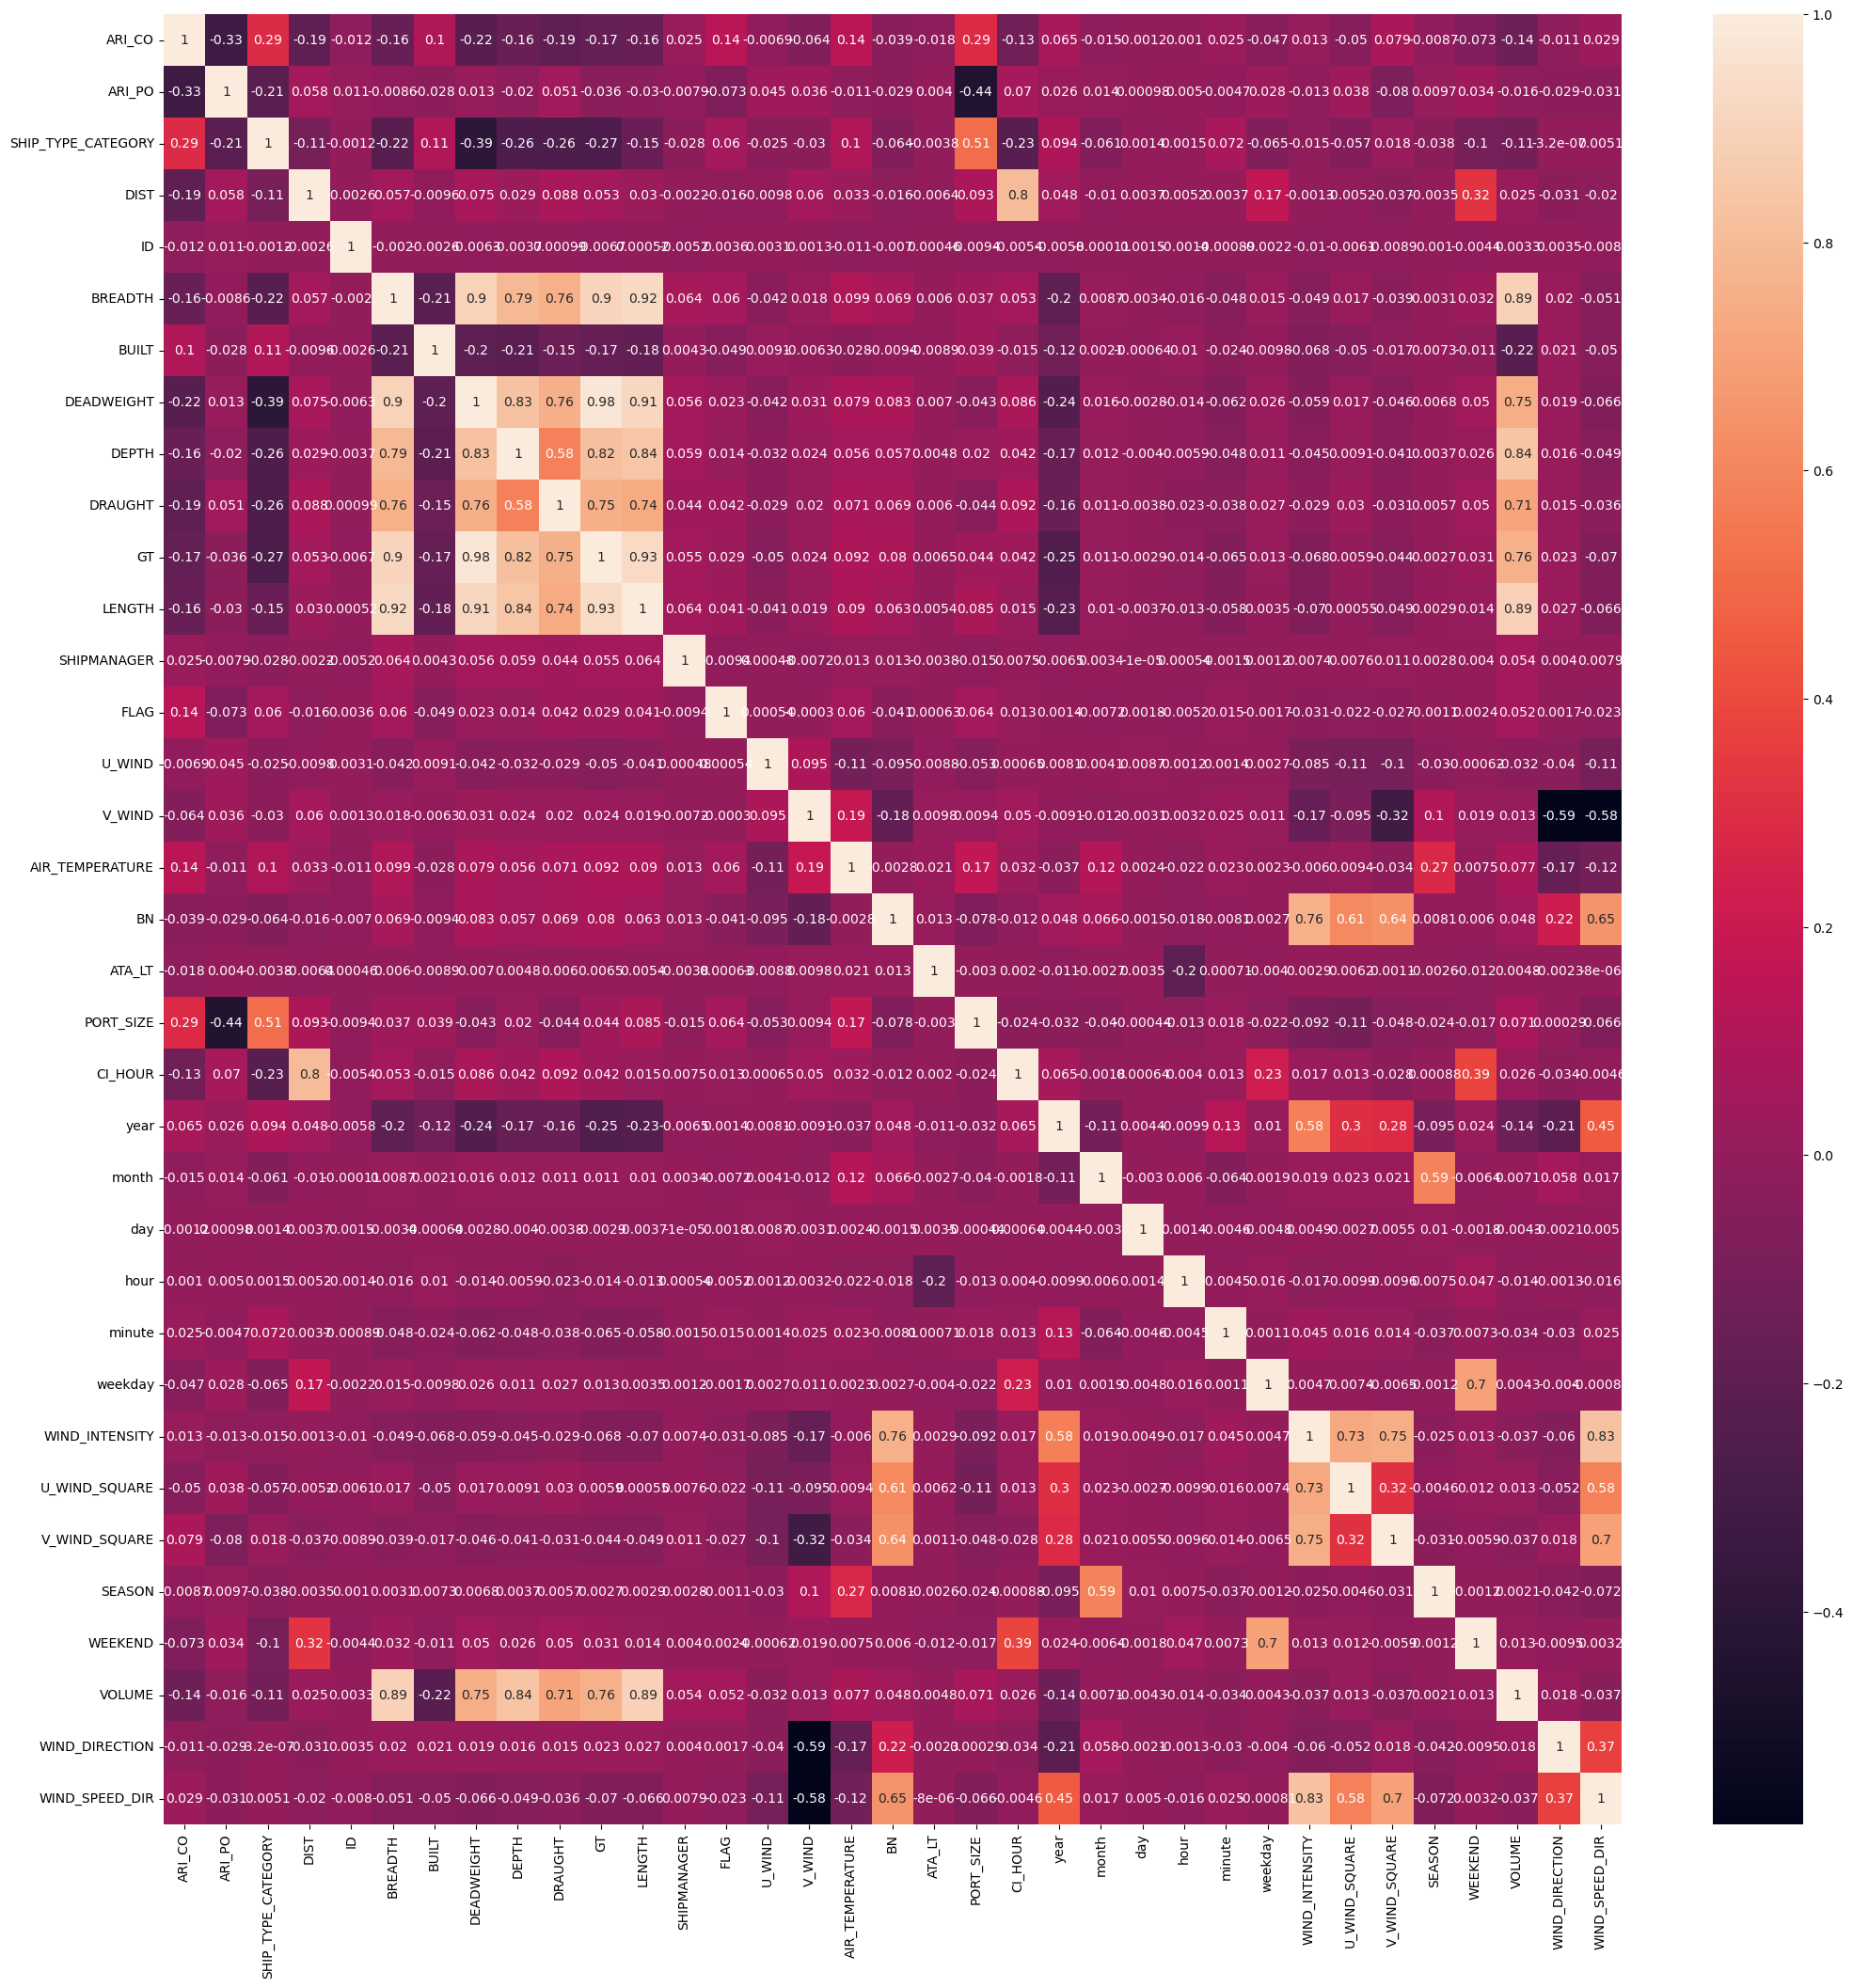

In [26]:
plt.figure(figsize = (25, 25))
sns.heatmap(train_co.corr(), annot=True)

In [27]:
features = []


target_correlation = train_co.corr()['CI_HOUR'].drop('CI_HOUR')
high_correlation_features = target_correlation[abs(target_correlation) > 0.001].index

for feature in high_correlation_features:
    features.append(feature)
    print(f"Feature: {feature}, Coefficient: {target_correlation[feature]}")

Feature: ARI_CO, Coefficient: -0.13224556373380703
Feature: ARI_PO, Coefficient: 0.06986474821516139
Feature: SHIP_TYPE_CATEGORY, Coefficient: -0.22539941401225008
Feature: DIST, Coefficient: 0.8046049541622177
Feature: ID, Coefficient: -0.005382444227097965
Feature: BREADTH, Coefficient: 0.05349861612962958
Feature: BUILT, Coefficient: -0.014806802577496867
Feature: DEADWEIGHT, Coefficient: 0.0858161852188646
Feature: DEPTH, Coefficient: 0.04202386703281836
Feature: DRAUGHT, Coefficient: 0.09245514113209002
Feature: GT, Coefficient: 0.04241812218553203
Feature: LENGTH, Coefficient: 0.014818594206773871
Feature: SHIPMANAGER, Coefficient: 0.007458931394759506
Feature: FLAG, Coefficient: 0.013427382566989412
Feature: V_WIND, Coefficient: 0.050294442791571324
Feature: AIR_TEMPERATURE, Coefficient: 0.032124640800137744
Feature: BN, Coefficient: -0.012084326049880278
Feature: ATA_LT, Coefficient: 0.0019972087201406232
Feature: PORT_SIZE, Coefficient: -0.023926847666426707
Feature: year, Coe

In [28]:
len(features)

31

총 35개 feature 중 31개 selection

In [29]:
train = pd.concat([train[features], train['CI_HOUR']], axis=1)
test = test[features]

In [30]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR,CI_HOUR
0,17,21,2,3.462011,24710,30.0,24.0,10.098273,10.0,10.0,...,29,0,0.395712,0.086972,0.069616,0,54000.0,221.818222,87.776132,1.492904
1,7,81,0,0.000000,23140,30.0,13.0,10.488520,10.0,10.0,...,59,1,0.395712,0.086972,0.069616,0,54000.0,221.818222,87.776132,0.000000
2,4,14,2,0.000000,19009,50.0,12.0,11.891369,30.0,20.0,...,0,1,0.395712,0.086972,0.069616,0,555000.0,221.818222,87.776132,0.000000
3,8,101,2,0.000000,24048,20.0,18.0,8.840870,10.0,10.0,...,2,4,3.564337,10.112400,2.592100,0,24000.0,206.852606,737.292448,0.000000
4,17,21,2,3.333548,911,50.0,10.0,11.661354,20.0,10.0,...,51,6,3.296559,0.108900,10.758400,1,300000.0,264.254818,871.131550,5.539515


In [31]:
test.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,hour,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR
0,18,22,3,1.039071,9789,50.0,18.0,11.669938,30.0,20.0,...,11,58,3,1.671466,0.136900,2.656900,0,510000.0,77.210928,129.055473
1,5,91,2,3.273341,4185,10.0,13.0,8.245647,10.0,10.0,...,22,20,2,3.634969,7.784100,5.428900,0,8000.0,219.866116,799.206527
2,5,46,3,4.719208,5579,20.0,26.0,9.296610,10.0,10.0,...,0,9,0,4.910163,0.001600,24.108100,0,28000.0,270.466758,1328.035848
3,3,20,1,2.319959,735,30.0,9.0,10.929547,20.0,10.0,...,5,30,0,0.400482,0.086775,0.073611,0,114000.0,222.646110,89.165728
4,9,67,3,0.000000,848,30.0,19.0,10.591647,20.0,10.0,...,1,11,2,0.400482,0.086775,0.073611,0,132000.0,222.646110,89.165728


In [32]:
X_train = train.drop(columns = 'CI_HOUR')
y_train = train['CI_HOUR']

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(test)

X_train = pd.DataFrame(X_train_scaled, columns = features)
test = pd.DataFrame(test_scaled, columns = features)

In [33]:
X_train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,hour,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR
0,0.708333,0.205882,0.666667,0.652814,0.987334,0.4,0.3000,0.661095,0.333333,0.5,...,0.913043,0.491525,0.000000,0.012663,0.000136,0.000079,0.0,0.075000,0.616275,0.013002
1,0.291667,0.794118,0.000000,0.000000,0.924601,0.4,0.1625,0.708146,0.333333,0.5,...,0.260870,1.000000,0.166667,0.012663,0.000136,0.000079,0.0,0.075000,0.616275,0.013002
2,0.166667,0.137255,0.666667,0.000000,0.759540,0.8,0.1500,0.877285,1.000000,1.0,...,0.956522,0.000000,0.166667,0.012663,0.000136,0.000079,0.0,0.770833,0.616275,0.013002
3,0.333333,0.990196,0.666667,0.000000,0.960882,0.2,0.2250,0.509492,0.333333,0.5,...,0.173913,0.033898,0.666667,0.114059,0.015761,0.002941,0.0,0.033333,0.574696,0.109211
4,0.708333,0.205882,0.666667,0.628591,0.036401,0.8,0.1250,0.849553,0.666667,0.5,...,0.304348,0.864407,1.000000,0.105490,0.000170,0.012205,1.0,0.416667,0.734176,0.129036


In [34]:
y_train

0         1.492904
1         0.000000
2         0.000000
3         0.000000
4         5.539515
            ...   
391934    0.000000
391935    4.977157
391936    3.749086
391937    2.138333
391938    0.000000
Name: CI_HOUR, Length: 391939, dtype: float64

In [35]:
test.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,hour,minute,weekday,WIND_INTENSITY,U_WIND_SQUARE,V_WIND_SQUARE,WEEKEND,VOLUME,WIND_DIRECTION,WIND_SPEED_DIR
0,0.750000,0.215686,1.000000,0.195932,0.391138,0.8,0.2250,0.850588,1.000000,1.0,...,0.478261,0.983051,0.500000,0.053487,0.000213,0.003014,0.0,0.708333,0.214514,0.019116
1,0.208333,0.892157,0.666667,0.617238,0.167219,0.0,0.1625,0.437726,0.333333,0.5,...,0.956522,0.338983,0.333333,0.116319,0.012132,0.006159,0.0,0.011111,0.610851,0.118382
2,0.208333,0.450980,1.000000,0.889878,0.222919,0.2,0.3250,0.564439,0.333333,0.5,...,0.000000,0.152542,0.000000,0.157126,0.000002,0.027349,0.0,0.038889,0.751434,0.196714
3,0.125000,0.196078,0.333333,0.437463,0.029368,0.4,0.1125,0.761320,0.666667,0.5,...,0.217391,0.508475,0.000000,0.012815,0.000135,0.000084,0.0,0.158333,0.618575,0.013208
4,0.375000,0.656863,1.000000,0.000000,0.033883,0.4,0.2375,0.720580,0.666667,0.5,...,0.043478,0.186441,0.333333,0.012815,0.000135,0.000084,0.0,0.183333,0.618575,0.013208


In [36]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split

num_models = 3

def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 5),  
        'reg_alpha': trial.suggest_uniform('reg_alpha', 1e-3, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 1e-3, 0.1),
        'objective': 'reg:absoluteerror',
        'verbosity': 0
        }
    mae_list = []
    for i in range(num_models):
        X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
        model = xgb.XGBRegressor(**params)
        model.fit(X_train_m, y_train_m, eval_set=[(X_val_m, y_val_m)], early_stopping_rounds=100, verbose=False)
        preds = model.predict(X_val_m)
        mae = mean_absolute_error(y_val_m, preds)
        mae_list.append(mae)
    
    return np.mean(mae_list)

study1 = optuna.create_study(direction='minimize')
study1.optimize(optimize_xgboost, n_trials=50, show_progress_bar=True)

[I 2024-06-12 13:40:28,332] A new study created in memory with name: no-name-adb51430-6f00-4556-a9a7-6ac87dbb0e10


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:44:13,197] Trial 0 finished with value: 0.6439253248526747 and parameters: {'n_estimators': 842, 'learning_rate': 0.005244812568852817, 'max_depth': 17, 'min_child_weight': 158, 'subsample': 0.5529843031719979, 'colsample_bytree': 0.45141152403816515, 'gamma': 2.9804013008665557, 'reg_alpha': 0.7289595020299798, 'reg_lambda': 0.08806835106141865}. Best is trial 0 with value: 0.6439253248526747.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:47:15,980] Trial 1 finished with value: 0.5349746912064471 and parameters: {'n_estimators': 397, 'learning_rate': 0.031808347265911155, 'max_depth': 16, 'min_child_weight': 11, 'subsample': 0.6626365666875709, 'colsample_bytree': 0.5570200009036721, 'gamma': 2.122653879278171, 'reg_alpha': 0.9646312043490467, 'reg_lambda': 0.04783435791610842}. Best is trial 1 with value: 0.5349746912064471.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:52:27,837] Trial 2 finished with value: 0.7103149380188446 and parameters: {'n_estimators': 895, 'learning_rate': 0.0021326237085518033, 'max_depth': 13, 'min_child_weight': 74, 'subsample': 0.8812979034180229, 'colsample_bytree': 0.8262667922433446, 'gamma': 4.7716856370645955, 'reg_alpha': 0.9741298012418835, 'reg_lambda': 0.08187423264548521}. Best is trial 1 with value: 0.5349746912064471.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:53:28,686] Trial 3 finished with value: 0.4978029644497211 and parameters: {'n_estimators': 217, 'learning_rate': 0.05871849567998127, 'max_depth': 19, 'min_child_weight': 139, 'subsample': 0.5499188033362241, 'colsample_bytree': 0.9789684959054914, 'gamma': 3.9173794893389275, 'reg_alpha': 0.6141050491543076, 'reg_lambda': 0.08683805471015293}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:56:03,160] Trial 4 finished with value: 0.5874973323925402 and parameters: {'n_estimators': 533, 'learning_rate': 0.008718538406239701, 'max_depth': 14, 'min_child_weight': 183, 'subsample': 0.7706553946016664, 'colsample_bytree': 0.5715430026284096, 'gamma': 4.775060169109555, 'reg_alpha': 0.19473403790020824, 'reg_lambda': 0.004671104972587136}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 13:59:37,723] Trial 5 finished with value: 0.5047315308818358 and parameters: {'n_estimators': 604, 'learning_rate': 0.02085580863526912, 'max_depth': 16, 'min_child_weight': 51, 'subsample': 0.5856241999936831, 'colsample_bytree': 0.7600948161098604, 'gamma': 1.5059191298251546, 'reg_alpha': 0.09482088618245053, 'reg_lambda': 0.013831945345471275}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:01:56,824] Trial 6 finished with value: 1.2270625976873937 and parameters: {'n_estimators': 400, 'learning_rate': 0.001497204578418953, 'max_depth': 11, 'min_child_weight': 108, 'subsample': 0.8961764933186286, 'colsample_bytree': 0.8910991741690208, 'gamma': 3.99638857301144, 'reg_alpha': 0.08310444402231863, 'reg_lambda': 0.07351760228712659}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:05:08,093] Trial 7 finished with value: 0.914695145281283 and parameters: {'n_estimators': 551, 'learning_rate': 0.003106388963845303, 'max_depth': 14, 'min_child_weight': 53, 'subsample': 0.7791692177600937, 'colsample_bytree': 0.43813888399077766, 'gamma': 0.9143130124724652, 'reg_alpha': 0.7639008639748222, 'reg_lambda': 0.017391584473450364}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:10:08,187] Trial 8 finished with value: 0.5299085156177167 and parameters: {'n_estimators': 719, 'learning_rate': 0.08837351281331621, 'max_depth': 20, 'min_child_weight': 123, 'subsample': 0.8238516065579523, 'colsample_bytree': 0.43125160950675623, 'gamma': 2.3662368357082277, 'reg_alpha': 0.041617904189956804, 'reg_lambda': 0.02050679786206333}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:17:06,696] Trial 9 finished with value: 0.5251583085021172 and parameters: {'n_estimators': 933, 'learning_rate': 0.09174956172364572, 'max_depth': 15, 'min_child_weight': 14, 'subsample': 0.9067047629232448, 'colsample_bytree': 0.635081840253246, 'gamma': 0.3651329611474474, 'reg_alpha': 0.8462664806893997, 'reg_lambda': 0.02205146364110274}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:18:24,947] Trial 10 finished with value: 0.5000775952958536 and parameters: {'n_estimators': 213, 'learning_rate': 0.026062854077919338, 'max_depth': 20, 'min_child_weight': 148, 'subsample': 0.997744423988516, 'colsample_bytree': 0.9814889768863604, 'gamma': 3.4866161970156555, 'reg_alpha': 0.47867392089256533, 'reg_lambda': 0.061762656306140945}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:19:40,740] Trial 11 finished with value: 0.4982743170784338 and parameters: {'n_estimators': 210, 'learning_rate': 0.028024656125013484, 'max_depth': 20, 'min_child_weight': 146, 'subsample': 0.9709847426945898, 'colsample_bytree': 0.9830354879037599, 'gamma': 3.5816607377782343, 'reg_alpha': 0.44650684658561773, 'reg_lambda': 0.05752619621776305}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:20:45,286] Trial 12 finished with value: 0.4987354857720277 and parameters: {'n_estimators': 220, 'learning_rate': 0.04317566769004362, 'max_depth': 18, 'min_child_weight': 199, 'subsample': 0.6653210905239137, 'colsample_bytree': 0.9734663409268633, 'gamma': 3.7690464116469555, 'reg_alpha': 0.47845889289782517, 'reg_lambda': 0.05263480186583064}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:22:28,099] Trial 13 finished with value: 0.5316203356321928 and parameters: {'n_estimators': 347, 'learning_rate': 0.013940131943675698, 'max_depth': 19, 'min_child_weight': 139, 'subsample': 0.5153770801348483, 'colsample_bytree': 0.8654716495007112, 'gamma': 4.098240546484037, 'reg_alpha': 0.30948570620997595, 'reg_lambda': 0.09630553735193068}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:24:07,188] Trial 14 finished with value: 0.5046961523623573 and parameters: {'n_estimators': 323, 'learning_rate': 0.05207791050548194, 'max_depth': 18, 'min_child_weight': 172, 'subsample': 0.671521664806441, 'colsample_bytree': 0.9303903507452946, 'gamma': 3.0443351669211727, 'reg_alpha': 0.5645267532318379, 'reg_lambda': 0.040461501588447434}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:25:39,103] Trial 15 finished with value: 0.6212272885087154 and parameters: {'n_estimators': 205, 'learning_rate': 0.013125383102545967, 'max_depth': 20, 'min_child_weight': 121, 'subsample': 0.9952073947922001, 'colsample_bytree': 0.7803569936674797, 'gamma': 2.9695573962261905, 'reg_alpha': 0.6324523129032474, 'reg_lambda': 0.06902074007762726}. Best is trial 3 with value: 0.4978029644497211.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:28:10,513] Trial 16 finished with value: 0.4933439487359958 and parameters: {'n_estimators': 469, 'learning_rate': 0.0579613045049078, 'max_depth': 18, 'min_child_weight': 88, 'subsample': 0.6173103889300176, 'colsample_bytree': 0.9970331140869153, 'gamma': 4.587384969981544, 'reg_alpha': 0.33374705820160183, 'reg_lambda': 0.03571709223736173}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:30:46,462] Trial 17 finished with value: 0.5200252550946517 and parameters: {'n_estimators': 453, 'learning_rate': 0.06888272304662715, 'max_depth': 18, 'min_child_weight': 85, 'subsample': 0.610179178499304, 'colsample_bytree': 0.6916478374824833, 'gamma': 4.993139503198258, 'reg_alpha': 0.3258010886436613, 'reg_lambda': 0.03542211688614049}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:33:51,347] Trial 18 finished with value: 0.5067059574840496 and parameters: {'n_estimators': 679, 'learning_rate': 0.05137391482525358, 'max_depth': 10, 'min_child_weight': 91, 'subsample': 0.5045426015836214, 'colsample_bytree': 0.8775018937099694, 'gamma': 4.378295111281774, 'reg_alpha': 0.32842461208938967, 'reg_lambda': 0.033225078368440596}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:35:37,226] Trial 19 finished with value: 0.700927017132804 and parameters: {'n_estimators': 315, 'learning_rate': 0.006469965006858079, 'max_depth': 17, 'min_child_weight': 65, 'subsample': 0.6191086577574294, 'colsample_bytree': 0.7958564801696116, 'gamma': 4.388377331833002, 'reg_alpha': 0.5906426423142983, 'reg_lambda': 0.09482673332154554}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:39:21,630] Trial 20 finished with value: 0.49458482639266493 and parameters: {'n_estimators': 484, 'learning_rate': 0.020421473025072433, 'max_depth': 19, 'min_child_weight': 38, 'subsample': 0.7058033496589415, 'colsample_bytree': 0.9217404547909552, 'gamma': 1.7547357910982941, 'reg_alpha': 0.202626626208424, 'reg_lambda': 0.07317170999649683}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:43:03,897] Trial 21 finished with value: 0.49466965638941446 and parameters: {'n_estimators': 489, 'learning_rate': 0.019016091141316034, 'max_depth': 19, 'min_child_weight': 33, 'subsample': 0.7012394735682665, 'colsample_bytree': 0.9282716219904459, 'gamma': 1.9606802357775095, 'reg_alpha': 0.22299631093865763, 'reg_lambda': 0.07980168232482737}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:46:07,452] Trial 22 finished with value: 0.4937552278983481 and parameters: {'n_estimators': 518, 'learning_rate': 0.018937924994655266, 'max_depth': 19, 'min_child_weight': 32, 'subsample': 0.7220215930528371, 'colsample_bytree': 0.9195167537278527, 'gamma': 1.7545557646799395, 'reg_alpha': 0.235849496965321, 'reg_lambda': 0.07253178796082685}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:49:24,016] Trial 23 finished with value: 0.4939315106681534 and parameters: {'n_estimators': 619, 'learning_rate': 0.012738502184847709, 'max_depth': 17, 'min_child_weight': 35, 'subsample': 0.7347880935282729, 'colsample_bytree': 0.9124493333579522, 'gamma': 1.6660757015897216, 'reg_alpha': 0.1994164315703995, 'reg_lambda': 0.06538050210648522}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:52:58,734] Trial 24 finished with value: 0.5142144304796012 and parameters: {'n_estimators': 663, 'learning_rate': 0.01034990492038549, 'max_depth': 17, 'min_child_weight': 33, 'subsample': 0.732772110791201, 'colsample_bytree': 0.7298431682299389, 'gamma': 1.255475673966452, 'reg_alpha': 0.38130922390668676, 'reg_lambda': 0.06495305781760874}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 14:57:31,583] Trial 25 finished with value: 0.5677698064943343 and parameters: {'n_estimators': 763, 'learning_rate': 0.00445331979558634, 'max_depth': 16, 'min_child_weight': 19, 'subsample': 0.7994027340448999, 'colsample_bytree': 0.8280895303022492, 'gamma': 0.8547034729442482, 'reg_alpha': 0.1805199175306659, 'reg_lambda': 0.04651568975319462}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:00:33,240] Trial 26 finished with value: 0.5086045977988468 and parameters: {'n_estimators': 602, 'learning_rate': 0.007801084186674349, 'max_depth': 18, 'min_child_weight': 62, 'subsample': 0.8369934834692615, 'colsample_bytree': 0.9363923919553263, 'gamma': 0.032939391835295595, 'reg_alpha': 0.24882432232101437, 'reg_lambda': 0.028961706175368918}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:03:16,894] Trial 27 finished with value: 0.5021636004049674 and parameters: {'n_estimators': 556, 'learning_rate': 0.014995241356112719, 'max_depth': 17, 'min_child_weight': 44, 'subsample': 0.7284790523529148, 'colsample_bytree': 0.8372486946217643, 'gamma': 2.6749802776419735, 'reg_alpha': 0.12747894701032317, 'reg_lambda': 0.05301560190999868}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:06:30,445] Trial 28 finished with value: 1.052826573719093 and parameters: {'n_estimators': 808, 'learning_rate': 0.0010033066669338135, 'max_depth': 15, 'min_child_weight': 77, 'subsample': 0.6372798031482243, 'colsample_bytree': 0.9993731688094717, 'gamma': 1.1626237692019736, 'reg_alpha': 0.3853445825096762, 'reg_lambda': 0.04192116732341393}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:10:24,093] Trial 29 finished with value: 0.5567164061337607 and parameters: {'n_estimators': 643, 'learning_rate': 0.03657620492562314, 'max_depth': 16, 'min_child_weight': 5, 'subsample': 0.5758150883966112, 'colsample_bytree': 0.5011966947282174, 'gamma': 1.6878017566577617, 'reg_alpha': 0.2840680744315767, 'reg_lambda': 0.06063731000401838}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:12:45,926] Trial 30 finished with value: 0.7904754372044648 and parameters: {'n_estimators': 415, 'learning_rate': 0.0043541752450305775, 'max_depth': 18, 'min_child_weight': 27, 'subsample': 0.7527213375032243, 'colsample_bytree': 0.6736227965221349, 'gamma': 2.4120056851729137, 'reg_alpha': 0.007297204442559324, 'reg_lambda': 0.07266616208831023}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:15:29,515] Trial 31 finished with value: 0.4939525670092257 and parameters: {'n_estimators': 498, 'learning_rate': 0.021001606573270333, 'max_depth': 19, 'min_child_weight': 41, 'subsample': 0.7022389535977314, 'colsample_bytree': 0.9165788254966998, 'gamma': 1.8633768972916358, 'reg_alpha': 0.15581176757205883, 'reg_lambda': 0.07836675775462579}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:18:43,973] Trial 32 finished with value: 0.5072543243662381 and parameters: {'n_estimators': 509, 'learning_rate': 0.010701558826433434, 'max_depth': 19, 'min_child_weight': 22, 'subsample': 0.6927496715447666, 'colsample_bytree': 0.8913597085726248, 'gamma': 2.05404133781812, 'reg_alpha': 0.14717789711971158, 'reg_lambda': 0.08038144463553051}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:20:33,115] Trial 33 finished with value: 0.4952211086751966 and parameters: {'n_estimators': 426, 'learning_rate': 0.034516940149601785, 'max_depth': 17, 'min_child_weight': 63, 'subsample': 0.6424963675076486, 'colsample_bytree': 0.949579887339349, 'gamma': 1.3552850861686185, 'reg_alpha': 0.3869039253820778, 'reg_lambda': 0.08872821445817368}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:22:56,989] Trial 34 finished with value: 0.4959013870266089 and parameters: {'n_estimators': 592, 'learning_rate': 0.0266018589492266, 'max_depth': 19, 'min_child_weight': 98, 'subsample': 0.6839012397794463, 'colsample_bytree': 0.9012072981764205, 'gamma': 2.76619477528206, 'reg_alpha': 0.24654377123870408, 'reg_lambda': 0.08832399944999267}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:24:48,984] Trial 35 finished with value: 0.508179447524186 and parameters: {'n_estimators': 372, 'learning_rate': 0.016845170266161433, 'max_depth': 18, 'min_child_weight': 46, 'subsample': 0.7443587333642797, 'colsample_bytree': 0.8417115412461931, 'gamma': 2.231159619934055, 'reg_alpha': 0.15116509237599934, 'reg_lambda': 0.06667049046268551}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:28:51,804] Trial 36 finished with value: 0.5302485182207498 and parameters: {'n_estimators': 563, 'learning_rate': 0.006567999330840095, 'max_depth': 17, 'min_child_weight': 7, 'subsample': 0.7151698990935644, 'colsample_bytree': 0.9554102610852109, 'gamma': 1.7874276003330185, 'reg_alpha': 0.07483791097200038, 'reg_lambda': 0.07771219438518967}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:30:43,280] Trial 37 finished with value: 0.517496748320183 and parameters: {'n_estimators': 449, 'learning_rate': 0.011986459977399512, 'max_depth': 20, 'min_child_weight': 73, 'subsample': 0.5503098253368488, 'colsample_bytree': 0.8623042808793127, 'gamma': 0.8317597172769309, 'reg_alpha': 0.2703720736421018, 'reg_lambda': 0.0840947913735254}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:34:57,694] Trial 38 finished with value: 0.510670945949442 and parameters: {'n_estimators': 992, 'learning_rate': 0.06802557559803159, 'max_depth': 16, 'min_child_weight': 109, 'subsample': 0.7712562067601181, 'colsample_bytree': 0.7872720281774117, 'gamma': 3.2371505496764432, 'reg_alpha': 0.3743336316443321, 'reg_lambda': 0.057478826839714045}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:37:30,956] Trial 39 finished with value: 0.49967378951215524 and parameters: {'n_estimators': 708, 'learning_rate': 0.024459798374290416, 'max_depth': 12, 'min_child_weight': 50, 'subsample': 0.805328665832636, 'colsample_bytree': 0.7428104980747386, 'gamma': 2.6340983880207682, 'reg_alpha': 0.11850034711143351, 'reg_lambda': 0.04755120633052281}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:39:58,354] Trial 40 finished with value: 0.49725363971620656 and parameters: {'n_estimators': 527, 'learning_rate': 0.0371603832169851, 'max_depth': 19, 'min_child_weight': 57, 'subsample': 0.6472373946982266, 'colsample_bytree': 0.9108121878136244, 'gamma': 1.518753116731803, 'reg_alpha': 0.4316960679669402, 'reg_lambda': 0.07580529830357097}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:42:31,979] Trial 41 finished with value: 0.5250156323506999 and parameters: {'n_estimators': 488, 'learning_rate': 0.008421506767927073, 'max_depth': 19, 'min_child_weight': 39, 'subsample': 0.7022167837504777, 'colsample_bytree': 0.9162383907879523, 'gamma': 1.9562108275888925, 'reg_alpha': 0.19563634569022828, 'reg_lambda': 0.07070081727730851}. Best is trial 16 with value: 0.4933439487359958.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:44:58,455] Trial 42 finished with value: 0.49275068583330633 and parameters: {'n_estimators': 469, 'learning_rate': 0.021209778069074856, 'max_depth': 19, 'min_child_weight': 33, 'subsample': 0.5982050054844394, 'colsample_bytree': 0.9523210805623685, 'gamma': 1.7018125712824468, 'reg_alpha': 0.21421694781522616, 'reg_lambda': 0.06578117488009795}. Best is trial 42 with value: 0.49275068583330633.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:49:03,021] Trial 43 finished with value: 0.48664683855105517 and parameters: {'n_estimators': 631, 'learning_rate': 0.01751075255019035, 'max_depth': 18, 'min_child_weight': 14, 'subsample': 0.6022395832747942, 'colsample_bytree': 0.998362723110201, 'gamma': 1.1174162846621036, 'reg_alpha': 0.07983693129063558, 'reg_lambda': 0.0038247585969576822}. Best is trial 43 with value: 0.48664683855105517.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 15:57:19,509] Trial 44 finished with value: 0.49741589336407266 and parameters: {'n_estimators': 639, 'learning_rate': 0.016650219789810575, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.5862549599956217, 'colsample_bytree': 0.9997509664149886, 'gamma': 1.0513736778210352, 'reg_alpha': 0.06310271199813153, 'reg_lambda': 0.0024062678791712186}. Best is trial 43 with value: 0.48664683855105517.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 16:02:31,214] Trial 45 finished with value: 0.49757643020509335 and parameters: {'n_estimators': 571, 'learning_rate': 0.03059206676966986, 'max_depth': 17, 'min_child_weight': 13, 'subsample': 0.5320471580276023, 'colsample_bytree': 0.9642611486031327, 'gamma': 0.5530090689300504, 'reg_alpha': 0.019983665900112635, 'reg_lambda': 0.00925420797353143}. Best is trial 43 with value: 0.48664683855105517.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 16:06:16,378] Trial 46 finished with value: 0.5194640870431266 and parameters: {'n_estimators': 630, 'learning_rate': 0.043434138637349615, 'max_depth': 14, 'min_child_weight': 20, 'subsample': 0.6020091805379295, 'colsample_bytree': 0.5959412910989484, 'gamma': 1.5287484847309207, 'reg_alpha': 0.2303864903004408, 'reg_lambda': 0.027565132725789764}. Best is trial 43 with value: 0.48664683855105517.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 16:08:31,408] Trial 47 finished with value: 0.49980038606864924 and parameters: {'n_estimators': 278, 'learning_rate': 0.022986289915096606, 'max_depth': 20, 'min_child_weight': 27, 'subsample': 0.5645178666722488, 'colsample_bytree': 0.9550202781149733, 'gamma': 0.6539642472654207, 'reg_alpha': 0.10265278617750559, 'reg_lambda': 0.01486095273674417}. Best is trial 43 with value: 0.48664683855105517.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 16:14:17,762] Trial 48 finished with value: 0.4829285759522444 and parameters: {'n_estimators': 729, 'learning_rate': 0.01327605055081743, 'max_depth': 18, 'min_child_weight': 29, 'subsample': 0.8504017227981691, 'colsample_bytree': 0.9997764771243957, 'gamma': 2.222285448476013, 'reg_alpha': 0.29487337452862183, 'reg_lambda': 0.06254518673849829}. Best is trial 48 with value: 0.4829285759522444.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\2443837467.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\User

[I 2024-06-12 16:24:01,988] Trial 49 finished with value: 0.5649872082121596 and parameters: {'n_estimators': 852, 'learning_rate': 0.003193756396926517, 'max_depth': 20, 'min_child_weight': 13, 'subsample': 0.8342524159960867, 'colsample_bytree': 0.9720686588671114, 'gamma': 2.2946910108437217, 'reg_alpha': 0.2981456398264668, 'reg_lambda': 0.056123930016230734}. Best is trial 48 with value: 0.4829285759522444.


In [37]:
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import catboost as cb

num_models = 3

def optimize_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 7, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 5),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_uniform('random_strength', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.4, 1.0),
        'loss_function': 'MAE',
        'verbose': 0
    }
    mae_list = []
    for i in range(num_models):
        X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
        model = cb.CatBoostRegressor(**params)
        model.fit(X_train_m, y_train_m, eval_set=(X_val_m, y_val_m), early_stopping_rounds=100, verbose=False)
        preds = model.predict(X_val_m)
        mae = mean_absolute_error(y_val_m, preds)
        mae_list.append(mae)
    
    return np.mean(mae_list)

study2 = optuna.create_study(direction='minimize')
study2.optimize(optimize_catboost, n_trials=50, show_progress_bar=True)


[I 2024-06-12 16:24:02,369] A new study created in memory with name: no-name-6e2d93ec-8593-4f28-bcfd-c765c0e240dd


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:27:29,301] Trial 0 finished with value: 0.5243825726859104 and parameters: {'iterations': 731, 'learning_rate': 0.024214496932882478, 'depth': 10, 'l2_leaf_reg': 0.001371395122681184, 'bagging_temperature': 2.4427357409449755, 'border_count': 126, 'random_strength': 2.8525745468710384, 'subsample': 0.7448923210138068, 'colsample_bylevel': 0.7589519841769898}. Best is trial 0 with value: 0.5243825726859104.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:28:36,201] Trial 1 finished with value: 0.5223851672118532 and parameters: {'iterations': 328, 'learning_rate': 0.0807680022219149, 'depth': 8, 'l2_leaf_reg': 0.0010035287685245, 'bagging_temperature': 4.995088310734698, 'border_count': 162, 'random_strength': 3.457105866974434, 'subsample': 0.5027728098913279, 'colsample_bylevel': 0.7998803153137477}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:31:27,592] Trial 2 finished with value: 0.6260768893612596 and parameters: {'iterations': 595, 'learning_rate': 0.005041800844510379, 'depth': 10, 'l2_leaf_reg': 0.6564319105775419, 'bagging_temperature': 2.790640894258909, 'border_count': 33, 'random_strength': 6.7703390225657625, 'subsample': 0.6821774279624742, 'colsample_bylevel': 0.9716140772837646}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:40:52,129] Trial 3 finished with value: 0.5332352966890945 and parameters: {'iterations': 706, 'learning_rate': 0.020882696026851937, 'depth': 14, 'l2_leaf_reg': 0.6665258612291521, 'bagging_temperature': 3.502850901907811, 'border_count': 229, 'random_strength': 7.011768099011827, 'subsample': 0.8661408102387421, 'colsample_bylevel': 0.5405515604691165}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:42:37,867] Trial 4 finished with value: 0.5356708868178216 and parameters: {'iterations': 214, 'learning_rate': 0.05557673226711447, 'depth': 14, 'l2_leaf_reg': 0.0015609093627527472, 'bagging_temperature': 3.0125143273413073, 'border_count': 120, 'random_strength': 3.5542158664240544, 'subsample': 0.956729949508707, 'colsample_bylevel': 0.7499774894587545}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:43:40,111] Trial 5 finished with value: 0.552370143275231 and parameters: {'iterations': 383, 'learning_rate': 0.01680791907739683, 'depth': 10, 'l2_leaf_reg': 0.0415422853105284, 'bagging_temperature': 2.7684759651941726, 'border_count': 223, 'random_strength': 1.639164177892698, 'subsample': 0.8162090406017246, 'colsample_bylevel': 0.4643046313423391}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:45:33,187] Trial 6 finished with value: 0.7772883755835505 and parameters: {'iterations': 715, 'learning_rate': 0.0022398606131941116, 'depth': 11, 'l2_leaf_reg': 0.009210224072661402, 'bagging_temperature': 4.097292300729877, 'border_count': 82, 'random_strength': 2.0170779371434424, 'subsample': 0.743073694410968, 'colsample_bylevel': 0.44937084284851836}. Best is trial 1 with value: 0.5223851672118532.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:47:30,616] Trial 7 finished with value: 0.5221132498153471 and parameters: {'iterations': 770, 'learning_rate': 0.02542109900214634, 'depth': 10, 'l2_leaf_reg': 0.4901636115973358, 'bagging_temperature': 4.913442595964565, 'border_count': 85, 'random_strength': 7.480069965415791, 'subsample': 0.5140695894651668, 'colsample_bylevel': 0.8841031726409041}. Best is trial 7 with value: 0.5221132498153471.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:49:26,633] Trial 8 finished with value: 0.5137035438105665 and parameters: {'iterations': 781, 'learning_rate': 0.03155649517477686, 'depth': 9, 'l2_leaf_reg': 0.001406965095413576, 'bagging_temperature': 1.2837852833508627, 'border_count': 133, 'random_strength': 1.8026453547747467, 'subsample': 0.843660273044194, 'colsample_bylevel': 0.8634972014089696}. Best is trial 8 with value: 0.5137035438105665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 16:55:02,304] Trial 9 finished with value: 0.5035554598718051 and parameters: {'iterations': 262, 'learning_rate': 0.06278757968065729, 'depth': 15, 'l2_leaf_reg': 0.02090457006945147, 'bagging_temperature': 4.368485495571022, 'border_count': 246, 'random_strength': 0.050484875767082826, 'subsample': 0.8194236091019755, 'colsample_bylevel': 0.5484372889442893}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:16:34,860] Trial 10 finished with value: 0.552948136211085 and parameters: {'iterations': 990, 'learning_rate': 0.006785625267799638, 'depth': 15, 'l2_leaf_reg': 0.06019392422279471, 'bagging_temperature': 0.13824540471838231, 'border_count': 253, 'random_strength': 9.445262075083582, 'subsample': 0.9916123489153033, 'colsample_bylevel': 0.6192729606564003}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:18:30,849] Trial 11 finished with value: 0.5179128507558355 and parameters: {'iterations': 519, 'learning_rate': 0.045758960994056914, 'depth': 8, 'l2_leaf_reg': 0.007780154161230955, 'bagging_temperature': 1.3194519989112998, 'border_count': 176, 'random_strength': 0.5541192414780749, 'subsample': 0.8737048633849115, 'colsample_bylevel': 0.634390377929331}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:25:48,598] Trial 12 finished with value: 0.5065180582106771 and parameters: {'iterations': 917, 'learning_rate': 0.049241664505017546, 'depth': 13, 'l2_leaf_reg': 0.007607088941682618, 'bagging_temperature': 1.488426085453304, 'border_count': 193, 'random_strength': 0.8302864114111796, 'subsample': 0.6452319102030788, 'colsample_bylevel': 0.8797481232969201}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:29:35,484] Trial 13 finished with value: 0.5101990801525181 and parameters: {'iterations': 992, 'learning_rate': 0.09900495850642833, 'depth': 13, 'l2_leaf_reg': 0.011691666289586814, 'bagging_temperature': 1.640095559244918, 'border_count': 202, 'random_strength': 0.30695651629479237, 'subsample': 0.6256348174687711, 'colsample_bylevel': 0.6455373661788636}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:34:21,734] Trial 14 finished with value: 0.5698791781879609 and parameters: {'iterations': 462, 'learning_rate': 0.009743708885173652, 'depth': 13, 'l2_leaf_reg': 0.12274876111056826, 'bagging_temperature': 0.20150554985050384, 'border_count': 254, 'random_strength': 4.813032956957235, 'subsample': 0.6280546851786344, 'colsample_bylevel': 0.9925695533830132}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:37:37,425] Trial 15 finished with value: 0.5045589486835693 and parameters: {'iterations': 866, 'learning_rate': 0.05571884163332363, 'depth': 12, 'l2_leaf_reg': 0.016013317072303253, 'bagging_temperature': 1.9627070449706414, 'border_count': 201, 'random_strength': 0.22100981479042803, 'subsample': 0.59231212434147, 'colsample_bylevel': 0.5444869406999353}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:38:36,589] Trial 16 finished with value: 1.3476581558305287 and parameters: {'iterations': 209, 'learning_rate': 0.0020750735177616332, 'depth': 12, 'l2_leaf_reg': 0.020980869775762655, 'bagging_temperature': 3.8955066623866177, 'border_count': 218, 'random_strength': 0.030709787406729444, 'subsample': 0.5791320491449352, 'colsample_bylevel': 0.5377962143361175}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:47:50,728] Trial 17 finished with value: 1.0530926630117274 and parameters: {'iterations': 849, 'learning_rate': 0.00102438779751824, 'depth': 15, 'l2_leaf_reg': 0.138302491743137, 'bagging_temperature': 1.9667411505850156, 'border_count': 188, 'random_strength': 4.892353670421995, 'subsample': 0.8058677872252887, 'colsample_bylevel': 0.40832123356401295}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:49:06,911] Trial 18 finished with value: 0.5662455510899295 and parameters: {'iterations': 624, 'learning_rate': 0.014333199935825094, 'depth': 7, 'l2_leaf_reg': 0.02138420263174082, 'bagging_temperature': 0.7548326155982279, 'border_count': 242, 'random_strength': 2.6836356207258043, 'subsample': 0.7038894598825587, 'colsample_bylevel': 0.5475089610645111}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:50:42,545] Trial 19 finished with value: 0.5071548481827272 and parameters: {'iterations': 319, 'learning_rate': 0.07354845288607892, 'depth': 12, 'l2_leaf_reg': 0.0031356614736526896, 'bagging_temperature': 2.159873931181875, 'border_count': 158, 'random_strength': 1.2290347508495791, 'subsample': 0.9110682416135103, 'colsample_bylevel': 0.6962948117158255}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:52:41,813] Trial 20 finished with value: 0.5188787634403248 and parameters: {'iterations': 486, 'learning_rate': 0.038088761500582734, 'depth': 12, 'l2_leaf_reg': 0.00364197044135956, 'bagging_temperature': 4.398097966007967, 'border_count': 212, 'random_strength': 5.61716136156844, 'subsample': 0.5653454722813978, 'colsample_bylevel': 0.5755492548370017}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 17:57:19,735] Trial 21 finished with value: 0.5114697077412493 and parameters: {'iterations': 884, 'learning_rate': 0.05458855189726819, 'depth': 14, 'l2_leaf_reg': 0.005528997676222718, 'bagging_temperature': 0.9259493751778818, 'border_count': 191, 'random_strength': 1.020210375901228, 'subsample': 0.6589630780460143, 'colsample_bylevel': 0.4894865532687303}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:00:40,716] Trial 22 finished with value: 0.505281346642933 and parameters: {'iterations': 913, 'learning_rate': 0.06327794777736427, 'depth': 13, 'l2_leaf_reg': 0.017707109828907424, 'bagging_temperature': 3.378426870326948, 'border_count': 233, 'random_strength': 0.12441846588864086, 'subsample': 0.5764041682277299, 'colsample_bylevel': 0.689509385752387}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:04:16,793] Trial 23 finished with value: 0.5087016210594145 and parameters: {'iterations': 813, 'learning_rate': 0.09728933116195077, 'depth': 14, 'l2_leaf_reg': 0.017406679291786607, 'bagging_temperature': 3.3234496370962323, 'border_count': 233, 'random_strength': 0.09824304474640554, 'subsample': 0.5637081081115893, 'colsample_bylevel': 0.6756987088648714}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:17:53,601] Trial 24 finished with value: 0.5120346176444603 and parameters: {'iterations': 935, 'learning_rate': 0.03388483658819417, 'depth': 15, 'l2_leaf_reg': 0.07506923323377011, 'bagging_temperature': 3.5764422901009905, 'border_count': 238, 'random_strength': 2.5964873447568166, 'subsample': 0.7828696089932723, 'colsample_bylevel': 0.5889444692328185}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:19:56,854] Trial 25 finished with value: 0.5055958747149972 and parameters: {'iterations': 636, 'learning_rate': 0.06069864688709817, 'depth': 11, 'l2_leaf_reg': 0.03669505576170294, 'bagging_temperature': 4.519714901051465, 'border_count': 207, 'random_strength': 3.9101594809646674, 'subsample': 0.5462181426799486, 'colsample_bylevel': 0.49787940507211564}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:25:56,022] Trial 26 finished with value: 0.5084447256172352 and parameters: {'iterations': 885, 'learning_rate': 0.0361953817332225, 'depth': 13, 'l2_leaf_reg': 0.23635808265724248, 'bagging_temperature': 3.1403783837105275, 'border_count': 172, 'random_strength': 1.3674142578905748, 'subsample': 0.588322451571301, 'colsample_bylevel': 0.7334398631343534}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:28:59,094] Trial 27 finished with value: 0.5539335173240346 and parameters: {'iterations': 830, 'learning_rate': 0.012112881044969239, 'depth': 11, 'l2_leaf_reg': 0.02506454204426895, 'bagging_temperature': 3.879103570171357, 'border_count': 255, 'random_strength': 9.530964350455447, 'subsample': 0.7073568974912678, 'colsample_bylevel': 0.5967975838011936}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:32:48,077] Trial 28 finished with value: 0.5037267830384042 and parameters: {'iterations': 674, 'learning_rate': 0.07106954814386882, 'depth': 12, 'l2_leaf_reg': 0.016477044243731892, 'bagging_temperature': 2.4644021938801117, 'border_count': 218, 'random_strength': 0.7715471504879705, 'subsample': 0.7630350469580154, 'colsample_bylevel': 0.6665947157319289}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:35:52,240] Trial 29 finished with value: 0.5173007159126871 and parameters: {'iterations': 684, 'learning_rate': 0.025055118007486856, 'depth': 12, 'l2_leaf_reg': 0.004033741258714508, 'bagging_temperature': 2.4270310743571986, 'border_count': 149, 'random_strength': 2.1472989776192666, 'subsample': 0.7415793142158706, 'colsample_bylevel': 0.6542932739051772}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:37:32,476] Trial 30 finished with value: 0.5037577928139868 and parameters: {'iterations': 570, 'learning_rate': 0.08476101924280306, 'depth': 11, 'l2_leaf_reg': 0.01129610078342776, 'bagging_temperature': 2.3937809569261788, 'border_count': 112, 'random_strength': 0.7792488699535149, 'subsample': 0.773737978319903, 'colsample_bylevel': 0.4006291376452355}. Best is trial 9 with value: 0.5035554598718051.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:39:07,334] Trial 31 finished with value: 0.5034289852322665 and parameters: {'iterations': 548, 'learning_rate': 0.072266431868727, 'depth': 11, 'l2_leaf_reg': 0.013159697017098196, 'bagging_temperature': 2.2191628882065304, 'border_count': 105, 'random_strength': 0.8850321726279228, 'subsample': 0.7724745336821346, 'colsample_bylevel': 0.4151807368259128}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:40:46,159] Trial 32 finished with value: 0.5036526340803786 and parameters: {'iterations': 564, 'learning_rate': 0.07955036019163202, 'depth': 11, 'l2_leaf_reg': 0.011147271432384, 'bagging_temperature': 2.4528054866548836, 'border_count': 109, 'random_strength': 0.9848184620065104, 'subsample': 0.7693479218452299, 'colsample_bylevel': 0.40834204433052956}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:41:43,028] Trial 33 finished with value: 0.5141753521853452 and parameters: {'iterations': 401, 'learning_rate': 0.0758752118178009, 'depth': 9, 'l2_leaf_reg': 0.03546987099342151, 'bagging_temperature': 2.744049505283091, 'border_count': 92, 'random_strength': 2.368387484450925, 'subsample': 0.7718350509147881, 'colsample_bylevel': 0.4444380339519377}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:42:25,421] Trial 34 finished with value: 0.5212183291883111 and parameters: {'iterations': 288, 'learning_rate': 0.07429463998683035, 'depth': 9, 'l2_leaf_reg': 0.0025443962945872613, 'bagging_temperature': 2.2640295567403235, 'border_count': 53, 'random_strength': 1.3841317692909163, 'subsample': 0.8254742128963909, 'colsample_bylevel': 0.48926761703724486}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:43:46,262] Trial 35 finished with value: 0.5157268885785616 and parameters: {'iterations': 555, 'learning_rate': 0.040074967912118356, 'depth': 10, 'l2_leaf_reg': 0.006128996768687728, 'bagging_temperature': 1.8162873760747797, 'border_count': 102, 'random_strength': 3.589239728272224, 'subsample': 0.7187222454195787, 'colsample_bylevel': 0.42455766613007595}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:46:11,844] Trial 36 finished with value: 0.541604216865936 and parameters: {'iterations': 675, 'learning_rate': 0.019652638264026193, 'depth': 11, 'l2_leaf_reg': 0.06408811823683973, 'bagging_temperature': 2.6835426691825766, 'border_count': 64, 'random_strength': 3.030523649333883, 'subsample': 0.8935214765720552, 'colsample_bylevel': 0.7883272607564282}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:47:21,052] Trial 37 finished with value: 0.5493865672185839 and parameters: {'iterations': 430, 'learning_rate': 0.030369816835129536, 'depth': 10, 'l2_leaf_reg': 0.013847487740452401, 'bagging_temperature': 3.012690578485029, 'border_count': 137, 'random_strength': 4.273648363756739, 'subsample': 0.792874771841343, 'colsample_bylevel': 0.5226147841443327}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:48:43,044] Trial 38 finished with value: 0.5242529819386408 and parameters: {'iterations': 531, 'learning_rate': 0.04593742447382384, 'depth': 10, 'l2_leaf_reg': 0.0275863724230451, 'bagging_temperature': 2.1257704873826726, 'border_count': 119, 'random_strength': 5.99944064659512, 'subsample': 0.8404148958135026, 'colsample_bylevel': 0.4627091639102176}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:50:00,852] Trial 39 finished with value: 0.5186290638280868 and parameters: {'iterations': 259, 'learning_rate': 0.06955959283808576, 'depth': 14, 'l2_leaf_reg': 0.002084069681155077, 'bagging_temperature': 2.639223376405916, 'border_count': 67, 'random_strength': 8.281398758561352, 'subsample': 0.7447476429231389, 'colsample_bylevel': 0.4336414328533432}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:51:17,943] Trial 40 finished with value: 0.8417467990346564 and parameters: {'iterations': 358, 'learning_rate': 0.003777455808856829, 'depth': 11, 'l2_leaf_reg': 0.005228651649934311, 'bagging_temperature': 2.9759297444612347, 'border_count': 98, 'random_strength': 1.922999777415348, 'subsample': 0.6778268718641228, 'colsample_bylevel': 0.7356975577823479}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:52:58,074] Trial 41 finished with value: 0.5046471344321524 and parameters: {'iterations': 575, 'learning_rate': 0.09835959431263343, 'depth': 11, 'l2_leaf_reg': 0.01138398175156275, 'bagging_temperature': 2.4341184895813477, 'border_count': 114, 'random_strength': 0.7192032684971073, 'subsample': 0.7588385105030143, 'colsample_bylevel': 0.4025102716758369}. Best is trial 31 with value: 0.5034289852322665.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:54:52,244] Trial 42 finished with value: 0.5025555383720374 and parameters: {'iterations': 616, 'learning_rate': 0.08124092025101576, 'depth': 11, 'l2_leaf_reg': 0.010903907972706402, 'bagging_temperature': 2.4603972460571026, 'border_count': 114, 'random_strength': 0.8672524402798709, 'subsample': 0.8065635808346765, 'colsample_bylevel': 0.46917801296209116}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:57:51,799] Trial 43 finished with value: 0.503415077351587 and parameters: {'iterations': 752, 'learning_rate': 0.06194743568468413, 'depth': 12, 'l2_leaf_reg': 0.00844569104248672, 'bagging_temperature': 1.7963348211736283, 'border_count': 124, 'random_strength': 1.0155965338699986, 'subsample': 0.864035731889776, 'colsample_bylevel': 0.478822538617779}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 18:59:53,622] Trial 44 finished with value: 0.5037921212259986 and parameters: {'iterations': 734, 'learning_rate': 0.04552978533854762, 'depth': 10, 'l2_leaf_reg': 0.009212498195923742, 'bagging_temperature': 1.6898582216841564, 'border_count': 127, 'random_strength': 1.6858786104727614, 'subsample': 0.9274721687967478, 'colsample_bylevel': 0.4657487180057533}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 19:01:31,141] Trial 45 finished with value: 0.5069515008888131 and parameters: {'iterations': 626, 'learning_rate': 0.05661204125989971, 'depth': 9, 'l2_leaf_reg': 0.007964483373882376, 'bagging_temperature': 1.397428572247743, 'border_count': 142, 'random_strength': 1.3485784706229054, 'subsample': 0.8633924411385208, 'colsample_bylevel': 0.5076275428997441}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 19:02:56,895] Trial 46 finished with value: 0.5041316378846689 and parameters: {'iterations': 490, 'learning_rate': 0.084223003022427, 'depth': 11, 'l2_leaf_reg': 0.04433084500646028, 'bagging_temperature': 0.9398115157117459, 'border_count': 83, 'random_strength': 2.934994396686177, 'subsample': 0.8181038256007465, 'colsample_bylevel': 0.47184840383103704}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 19:04:36,727] Trial 47 finished with value: 0.5285123664517699 and parameters: {'iterations': 753, 'learning_rate': 0.02736599284883682, 'depth': 8, 'l2_leaf_reg': 0.005094695968674528, 'bagging_temperature': 1.9234725628789504, 'border_count': 106, 'random_strength': 0.4483745854923179, 'subsample': 0.8549364096916171, 'colsample_bylevel': 0.4341563913461723}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 19:08:01,413] Trial 48 finished with value: 0.5196029284966092 and parameters: {'iterations': 788, 'learning_rate': 0.020498603058849495, 'depth': 12, 'l2_leaf_reg': 0.010167429602266893, 'bagging_temperature': 2.2122554204268625, 'border_count': 132, 'random_strength': 1.630954859570249, 'subsample': 0.9525128022287092, 'colsample_bylevel': 0.5663641168670878}. Best is trial 42 with value: 0.5025555383720374.


C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1),
C:\Users\82109\AppData\Local\Temp\ipykernel_34184\3794584094.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_te

[I 2024-06-12 19:10:06,423] Trial 49 finished with value: 0.5540041704362445 and parameters: {'iterations': 598, 'learning_rate': 0.008078338347815172, 'depth': 10, 'l2_leaf_reg': 0.006914414272603094, 'bagging_temperature': 1.1606571915214667, 'border_count': 76, 'random_strength': 1.0280717567318058, 'subsample': 0.8832906429726247, 'colsample_bylevel': 0.936229262587709}. Best is trial 42 with value: 0.5025555383720374.


In [51]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

num_models = 5

def optimize_lightgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1),
        'objective': 'regression',
    }
    
    mae_list = []
    for i in range(num_models):
        X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
        model = lgb.LGBMRegressor(**params)
        
        model.fit(
            X_train_m, y_train_m,
            eval_set=[(X_val_m, y_val_m)],
            eval_metric='mae',
            callbacks=[lgb.early_stopping(stopping_rounds=100)]
        )
        
        preds = model.predict(X_val_m)
        mae = mean_absolute_error(y_val_m, preds)
        mae_list.append(mae)
    
    return np.mean(mae_list)

study3 = optuna.create_study(direction='minimize')
study3.optimize(optimize_lightgbm, n_trials=50, show_progress_bar=True)

[I 2024-06-12 20:46:58,657] A new study created in memory with name: no-name-0cbbd86b-9c40-4795-926e-af87b5e7173e


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[217]	valid_0's l1: 0.562588	valid_0's l2: 0.785007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[703]	valid_0's l1: 0.885183	valid_0's l2: 1.26056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[252]	valid_0's l1: 0.550555	valid_0's l2: 0.75405
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[574]	valid_0's l1: 0.53403	valid_0's l2: 0.734952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's l1: 0.524166	valid_0's l2: 0.725991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's l1: 0.521569	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.920945	valid_0's l2: 1.2972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.91641	valid_0's l2: 1.

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[227]	valid_0's l1: 1.53748	valid_0's l2: 3.03106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[227]	valid_0's l1: 1.53212	valid_0's l2: 3.

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[623]	valid_0's l1: 0.91023	valid_0's l2: 1.26569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[623]	valid_0's l1: 0.905797	valid_0's l2: 1

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[302]	valid_0's l1: 1.02261	valid_0's l2: 1.50988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation 

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[424]	valid_0's l1: 0.823856	valid_0's l2: 1.10356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[424]	valid_0's l1: 0.819427	valid_0's l2: 

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's l1: 0.511843	valid_0's l2: 0.726085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's l1: 0.510564	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's l1: 0.511289	valid_0's l2: 0.725063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l1: 0.512988	valid_0's l2: 0.729038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[826]	valid_0's l1: 0.507535	valid_0's l2: 0.736211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[808]	valid_0's l1: 0.51886	valid_0's l2: 0.709694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[862]	valid_0's l1: 0.514994	valid_0's l2: 0.750429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[743]	valid_0's l1: 0.525256	valid_0's l2: 0.723025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[743]	valid_0's l1: 0.522508	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's l1: 0.557906	valid_0's l2: 0.822851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's l1: 0.528575	valid_0's l2: 0.738097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's l1: 0.525823	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[541]	valid_0's l1: 0.595807	valid_0's l2: 0.811094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[541]	valid_0's l1: 0.592395	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's l1: 0.521742	valid_0's l2: 0.71945
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's l1: 0.51955	valid_0's l2: 0

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's l1: 0.513964	valid_0's l2: 0.73195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's l1: 0.511979	valid_0's l2: 

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[914]	valid_0's l1: 0.51314	valid_0's l2: 0.721656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[914]	valid_0's l1: 0.511734	valid_0's l2: 

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[758]	valid_0's l1: 0.519392	valid_0's l2: 0.736706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[759]	valid_0's l1: 0.516879	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[660]	valid_0's l1: 0.520599	valid_0's l2: 0.752133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[804]	valid_0's l1: 0.522504	valid_0's l2: 0.729951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[891]	valid_0's l1: 0.517573	valid_0's l2: 0.740998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[958]	valid_0's l1: 0.526563	valid_0's l2: 0.720739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's l1: 0.524093	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's l1: 0.523357	valid_0's l2: 0.713963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[465]	valid_0's l1: 0.521449	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[801]	valid_0's l1: 0.608122	valid_0's l2: 0.821973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's l1: 0.524948	valid_0's l2: 0.725426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's l1: 0.523109	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[870]	valid_0's l1: 0.513725	valid_0's l2: 0.73134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l1: 0.510717	valid_0's l2: 0.722487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's l1: 0.520462	valid_0's l2: 0.725566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's l1: 0.512634	valid_0's l2: 0.719472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[881]	valid_0's l1: 0.512798	valid_0's l2: 0.721272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[823]	valid_0's l1: 0.51778	valid_0's l2: 0.714803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[681]	valid_0's l1: 0.541302	valid_0's l2: 0.746804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 0.514896	valid_0's l2: 0.752065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[959]	valid_0's l1: 0.578633	valid_0's l2: 0.796905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[776]	valid_0's l1: 0.541224	valid_0's l2: 0.767718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[776]	valid_0's l1: 0.538044	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 0.517036	valid_0's l2: 0.718163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[893]	valid_0's l1: 0.512302	valid_0's l2: 0.719054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's l1: 0.51703	valid_0's l2: 0.721945
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[920]	valid_0's l1: 0.509452	valid_0's l2: 0.711266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[840]	valid_0's l1: 0.518341	valid_0's l2: 0.726067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validatio

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's l1: 0.51707	valid_0's l2: 0.713322
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[717]	valid_0's l1: 0.584193	valid_0's l2: 0.800153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[717]	valid_0's l1: 0.580838	valid_0's l2:

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[858]	valid_0's l1: 0.708713	valid_0's l2: 0.962939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\82109\AppData\Local\Temp\ipykernel_20184\348584139.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
C:\Users\8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.162655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[285]	valid_0's l1: 0.530174	valid_0's l2: 0.730813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 31
[LightGBM] [Info] Start training from score 2.161773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[285]	valid_0's l1: 0.528744	valid_0's l2:

In [36]:
import xgboost as xgb

best_params1 = {'n_estimators': 729, 'learning_rate': 0.01327605055081743, 'max_depth': 18, 'min_child_weight': 29, 'subsample': 0.8504017227981691, 'colsample_bytree': 0.9997764771243957, 'gamma': 2.222285448476013, 'reg_alpha': 0.29487337452862183, 'reg_lambda': 0.06254518673849829}
best_score1 = 0.4829285759522444

print("Best Score:", best_score1)
print("Best Params:", best_params1)


model_xgb = xgb.XGBRegressor(**best_params1)
model_xgb.fit(X_train, y_train)

Best Score: 0.4829285759522444
Best Params: {'n_estimators': 729, 'learning_rate': 0.01327605055081743, 'max_depth': 18, 'min_child_weight': 29, 'subsample': 0.8504017227981691, 'colsample_bytree': 0.9997764771243957, 'gamma': 2.222285448476013, 'reg_alpha': 0.29487337452862183, 'reg_lambda': 0.06254518673849829}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9997764771243957, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.222285448476013,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01327605055081743,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=18, max_leaves=None,
             min_child_weight=29, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=729, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
import catboost as cb

best_params2 = {'iterations': 616, 'learning_rate': 0.08124092025101576, 'depth': 11, 'l2_leaf_reg': 0.010903907972706402, 'bagging_temperature': 2.4603972460571026, 'border_count': 114, 'random_strength': 0.8672524402798709, 'subsample': 0.8065635808346765, 'colsample_bylevel': 0.46917801296209116}
best_score2 = 0.5025555383720374

print("Best Score:", best_score2)
print("Best Params:", best_params2)


model_cb = cb.CatBoostRegressor(**best_params2)
model_cb.fit(X_train, y_train)

Best Score: 0.5025555383720374
Best Params: {'iterations': 616, 'learning_rate': 0.08124092025101576, 'depth': 11, 'l2_leaf_reg': 0.010903907972706402, 'bagging_temperature': 2.4603972460571026, 'border_count': 114, 'random_strength': 0.8672524402798709, 'subsample': 0.8065635808346765, 'colsample_bylevel': 0.46917801296209116}
0:	learn: 1.9671008	total: 184ms	remaining: 1m 53s
1:	learn: 1.8485530	total: 275ms	remaining: 1m 24s
2:	learn: 1.7413897	total: 356ms	remaining: 1m 12s
3:	learn: 1.6448204	total: 429ms	remaining: 1m 5s
4:	learn: 1.5604563	total: 501ms	remaining: 1m 1s
5:	learn: 1.4832738	total: 580ms	remaining: 58.9s
6:	learn: 1.4154225	total: 663ms	remaining: 57.7s
7:	learn: 1.3543349	total: 754ms	remaining: 57.3s
8:	learn: 1.3005024	total: 836ms	remaining: 56.4s
9:	learn: 1.2531110	total: 910ms	remaining: 55.1s
10:	learn: 1.2113034	total: 988ms	remaining: 54.4s
11:	learn: 1.1741556	total: 1.07s	remaining: 53.8s
12:	learn: 1.1419778	total: 1.15s	remaining: 53.4s
13:	learn: 1.1

156:	learn: 0.8523290	total: 12.8s	remaining: 37.4s
157:	learn: 0.8520787	total: 12.9s	remaining: 37.3s
158:	learn: 0.8517991	total: 13s	remaining: 37.2s
159:	learn: 0.8515689	total: 13s	remaining: 37.2s
160:	learn: 0.8511614	total: 13.1s	remaining: 37.1s
161:	learn: 0.8508339	total: 13.2s	remaining: 37s
162:	learn: 0.8503729	total: 13.3s	remaining: 36.9s
163:	learn: 0.8500890	total: 13.4s	remaining: 36.8s
164:	learn: 0.8495689	total: 13.4s	remaining: 36.7s
165:	learn: 0.8491815	total: 13.5s	remaining: 36.6s
166:	learn: 0.8488829	total: 13.6s	remaining: 36.5s
167:	learn: 0.8486776	total: 13.7s	remaining: 36.4s
168:	learn: 0.8483412	total: 13.7s	remaining: 36.3s
169:	learn: 0.8480464	total: 13.8s	remaining: 36.2s
170:	learn: 0.8475235	total: 13.9s	remaining: 36.1s
171:	learn: 0.8470608	total: 14s	remaining: 36.1s
172:	learn: 0.8467614	total: 14s	remaining: 36s
173:	learn: 0.8465112	total: 14.1s	remaining: 35.9s
174:	learn: 0.8462067	total: 14.2s	remaining: 35.8s
175:	learn: 0.8460225	to

315:	learn: 0.8040934	total: 25.3s	remaining: 24.1s
316:	learn: 0.8036547	total: 25.4s	remaining: 24s
317:	learn: 0.8033335	total: 25.5s	remaining: 23.9s
318:	learn: 0.8029748	total: 25.6s	remaining: 23.8s
319:	learn: 0.8026395	total: 25.7s	remaining: 23.8s
320:	learn: 0.8022842	total: 25.7s	remaining: 23.7s
321:	learn: 0.8020948	total: 25.8s	remaining: 23.6s
322:	learn: 0.8018481	total: 25.9s	remaining: 23.5s
323:	learn: 0.8015866	total: 26s	remaining: 23.4s
324:	learn: 0.8012386	total: 26.1s	remaining: 23.3s
325:	learn: 0.8007784	total: 26.2s	remaining: 23.3s
326:	learn: 0.8005355	total: 26.2s	remaining: 23.2s
327:	learn: 0.8002458	total: 26.3s	remaining: 23.1s
328:	learn: 0.8000753	total: 26.4s	remaining: 23s
329:	learn: 0.7997210	total: 26.5s	remaining: 22.9s
330:	learn: 0.7995115	total: 26.6s	remaining: 22.9s
331:	learn: 0.7993457	total: 26.6s	remaining: 22.8s
332:	learn: 0.7990918	total: 26.7s	remaining: 22.7s
333:	learn: 0.7988633	total: 26.8s	remaining: 22.6s
334:	learn: 0.7986

474:	learn: 0.7659639	total: 38.5s	remaining: 11.4s
475:	learn: 0.7657795	total: 38.5s	remaining: 11.3s
476:	learn: 0.7655272	total: 38.6s	remaining: 11.3s
477:	learn: 0.7652274	total: 38.7s	remaining: 11.2s
478:	learn: 0.7650406	total: 38.8s	remaining: 11.1s
479:	learn: 0.7648058	total: 38.9s	remaining: 11s
480:	learn: 0.7645563	total: 39s	remaining: 10.9s
481:	learn: 0.7643210	total: 39s	remaining: 10.9s
482:	learn: 0.7641277	total: 39.1s	remaining: 10.8s
483:	learn: 0.7638396	total: 39.2s	remaining: 10.7s
484:	learn: 0.7636587	total: 39.3s	remaining: 10.6s
485:	learn: 0.7635158	total: 39.4s	remaining: 10.5s
486:	learn: 0.7632978	total: 39.5s	remaining: 10.5s
487:	learn: 0.7630179	total: 39.6s	remaining: 10.4s
488:	learn: 0.7629038	total: 39.7s	remaining: 10.3s
489:	learn: 0.7627138	total: 39.7s	remaining: 10.2s
490:	learn: 0.7625595	total: 39.8s	remaining: 10.1s
491:	learn: 0.7622806	total: 39.9s	remaining: 10.1s
492:	learn: 0.7620700	total: 40s	remaining: 9.98s
493:	learn: 0.761861

In [52]:
best_trial = study3.best_trial
best_params3 = best_trial.params
best_score3 = best_trial.value

print("Best Score:", best_score3)
print("Best Params:", best_params3)


model_lgb = lgb.LGBMRegressor(**best_params3)
model_lgb.fit(X_train, y_train)

Best Score: 0.5059774409983775
Best Params: {'n_estimators': 826, 'learning_rate': 0.009638224292939241, 'num_leaves': 149, 'min_child_weight': 1, 'subsample': 0.5038909584524381, 'colsample_bytree': 0.9856278161268771, 'reg_alpha': 0.8017762513331148, 'reg_lambda': 0.019867065117048006}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4002
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 31
[LightGBM] [Info] Start training from score 2.163316


LGBMRegressor(colsample_bytree=0.9856278161268771,
              learning_rate=0.009638224292939241, min_child_weight=1,
              n_estimators=826, num_leaves=149, reg_alpha=0.8017762513331148,
              reg_lambda=0.019867065117048006, subsample=0.5038909584524381)

In [42]:
pred_xgb = np.expm1(model_xgb.predict(test))

In [44]:
pred_cb = np.expm1(model_cb.predict(test))

In [53]:
pred_lgb = np.expm1(model_lgb.predict(test))

In [64]:
pred = (pred_xgb + pred_cb + pred_lgb)/3

In [65]:
pred

array([1.48252259e+01, 1.88597358e+01, 6.15052887e+01, ...,
       2.83894404e+01, 9.75290550e-02, 1.51913590e+02])

In [66]:
submit = pd.read_csv('sample_submission.csv')
submit['CI_HOUR'] = pred
submit.to_csv('19th_submit.csv', index=False)